In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random, torch.backends.cudnn as cudnn
import re
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from rtdl_revisiting_models import  FTTransformer
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from sklearn.metrics import r2_score, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTENC
from tabm import TabM, EnsembleView, make_tabm_backbone, LinearEnsemble, MLPBackboneEnsemble, LayerNormEnsemble
from copy import deepcopy


In [3]:
df = pd.read_csv("D:\coding\CEPP_Model\CEPP\Process\convert_json_data.csv")
# df = df.iloc[:50_000].copy()
LABEL_ONLY_COLS = ["category_group"]
CATEGORICAL_FEATURES = [        
    'currency',
    'country_displayable_name',
    'location_state',
    "dur_bin",
]
NUMERIC_FEATURES = [
    # seasonality / timing (ใช้เวอร์ชัน cyclic เป็นหลัก)
    "launch_dow", "deadline_dow",
    "prep_days",
    "days_diff_launched_at_deadline","days_diff_launched_at_deadline_log",
    "too_short_or_long",

    # text/media
    "name_len","blurb_len","has_video","has_photo",

    # goal scale -> เก็บเฉพาะเวอร์ชัน log เพื่อลดซ้ำซ้อน
    "goal_usd_log","goal_per_day_log",
    
    # เลือกไม่กี่ตัวที่ “เป็นตัวแทน” จริง ๆ เพื่อลดซ้ำซ้อน
    "gpd_rank_in_cat_mon",     # เลือก rank ใน cat x month
    "goal_rank_in_cat_mon",
    "gpd_vs_cat_country_med",  # เลือก vs median สาย cat x country
    "goal_vs_cat_country_med",
    
    # 30-day density (ต่อหมวด-เวลา)
    "cat_30d_launch_density",
    "cat_30d_density_z",

    # group stats (goal-only) ต่อหมวด-เดือน
    "cat_mon_n","cat_mon_goal_med","cat_mon_gpd_med",
]
CYCLIC_NUMERIC = [ 
    'deadline_mon_sin',
    'deadline_mon_cos',
    'deadline_dom_sin',
    'deadline_dom_cos',  
    'launched_at_mon_sin',
    'launched_at_mon_cos',
    'launched_at_dom_sin',
    'launched_at_dom_cos',  
]

FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [4]:
label_encoders = {}
for col in CATEGORICAL_FEATURES:
    df[col] = df[col].fillna("missing").astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
for col in LABEL_ONLY_COLS:
    df[col] = df[col].fillna("missing").astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]) 
    label_encoders[col] = le

In [5]:
TARGET_FEATURE = {
    "success_cls": df["state"].to_numpy(dtype=np.int64),
    "risk_level": df["risk_level"].to_numpy(dtype=np.int64),
    "days_to_state_change": df["duration_class"].to_numpy(dtype=np.int64),
    "recommend_category": df["category_group"].to_numpy(dtype=np.int64),
    "goal_eval": df["goal_eval"].to_numpy(dtype=np.int64),
    "stretch_potential_cls": df["stretch_potential_cls"].to_numpy(dtype=np.int64),
}

key = df["category_group"].astype(str) + "_" + df["state"].astype(str)
# idx_train, idx_val = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42, stratify=key)
idx_train, idx_val = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42)
X_train_df = df.iloc[idx_train]
X_val_df = df.iloc[idx_val]



In [5]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.feature_selection import mutual_info_classif, f_classif
# from scipy.stats import spearmanr, pointbiserialr, chi2_contingency

# # ========= helpers (เหมือนเดิม + เพิ่ม multi-class) =========
# def cramers_v(x, y):
#     tbl = pd.crosstab(x, y)
#     if tbl.size == 0: return 0.0
#     chi2, _, _, _ = chi2_contingency(tbl)
#     n = tbl.values.sum()
#     if n <= 1: return 0.0
#     phi2 = chi2 / n
#     r, k = tbl.shape
#     phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
#     r_corr = r - (r-1)**2/(n-1)
#     k_corr = k - (k-1)**2/(n-1)
#     denom = max(1e-12, min(k_corr-1, r_corr-1))
#     return float(np.sqrt(phi2_corr / denom))

# def info_value_binary(x, y, nbins=10):
#     s = pd.Series(x)
#     if pd.api.types.is_numeric_dtype(s):
#         try:
#             s = pd.qcut(s, q=nbins, duplicates='drop')
#         except Exception:
#             s = pd.cut(s, bins=nbins)
#     df_ = pd.DataFrame({"x": s, "y": y})
#     g = df_.groupby("x")["y"]
#     bad  = (g.mean() * g.count()).fillna(0.0)    # y=1
#     good = ((1 - g.mean()) * g.count()).fillna(0.0)  # y=0
#     bad  = bad  / max(bad.sum(), 1.0)
#     good = good / max(good.sum(), 1.0)
#     woe = np.log((bad + 1e-9) / (good + 1e-9))
#     iv = ((bad - good) * woe).sum()
#     return float(iv)

# def info_value_ovr(x, y, nbins=10):  # macro |IV| บน one-vs-rest
#     classes = pd.unique(y)
#     vals = []
#     for c in classes:
#         yb = (y == c).astype(int)
#         try:
#             vals.append(abs(info_value_binary(x, yb, nbins=nbins)))
#         except Exception:
#             continue
#     return float(np.mean(vals)) if len(vals) else np.nan

# def pointbiserial_ovr(x, y):  # macro |r_pb| บน one-vs-rest
#     x = pd.to_numeric(pd.Series(x), errors='coerce')
#     maskx = x.notna().values
#     y = np.asarray(y)
#     classes = np.unique(y[maskx])
#     vals = []
#     for c in classes:
#         yb = (y == c).astype(int)[maskx]
#         r = pointbiserialr(yb, x[maskx]).correlation
#         if np.isfinite(r): vals.append(abs(r))
#     return float(np.mean(vals)) if len(vals) else np.nan

# def ensure_int_labels(y):
#     """คืน np.ndarray(int64) + จำนวนคลาส"""
#     y = pd.Series(y)
#     if not np.issubdtype(y.dtype, np.integer):
#         y = pd.factorize(y, sort=True)[0]
#     return y.astype(np.int64), int(pd.Series(y).nunique())

# # ========= ตารางสรุปความสัมพันธ์ (auto เลือก metric ตามชนิด target) =========
# def feature_target_report(df, target, numeric_features, categorical_features, topk_MI=200):
#     y, ncls = ensure_int_labels(target)
#     cols = list(numeric_features) + list(categorical_features)

#     # เตรียมสำหรับ MI
#     X_mi = pd.DataFrame(index=df.index)
#     for c in numeric_features:
#         X_mi[c] = pd.to_numeric(df[c], errors='coerce').fillna(df[c].median())
#     for c in categorical_features:
#         X_mi[c] = df[c].astype('category').cat.codes  # NaN -> -1
#     discrete_mask = X_mi.columns.isin(categorical_features)
#     mi = mutual_info_classif(X_mi.values, y, discrete_features=discrete_mask, random_state=0)

#     rows = []
#     for i, c in enumerate(X_mi.columns):
#         row = {"feature": c, "feat_type": "cat" if c in categorical_features else "num", "MI": mi[i]}

#         if c in numeric_features:
#             x = pd.to_numeric(df[c], errors='coerce')
#             if ncls == 2:
#                 # binary metrics
#                 sp = spearmanr(x, y, nan_policy='omit')
#                 row["spearman"] = float(sp.correlation) if np.isfinite(sp.correlation) else np.nan
#                 mask = x.notna()
#                 if mask.any():
#                     pb = pointbiserialr(y[mask], x[mask])
#                     row["pointbiserial"] = float(pb.correlation) if np.isfinite(pb.correlation) else np.nan
#                 else:
#                     row["pointbiserial"] = np.nan
#                 row["IV"] = info_value_binary(x, y)
#             else:
#                 # multi-class metrics
#                 try:
#                     F, p = f_classif(x.values.reshape(-1,1), y)
#                     row["anova_f"] = float(F[0]) if np.isfinite(F[0]) else np.nan
#                 except Exception:
#                     row["anova_f"] = np.nan
#                 row["pb_ovr"]  = pointbiserial_ovr(x, y)     # macro abs
#                 row["IV_ovr"]  = info_value_ovr(x, y)
#         else:
#             # categorical feature
#             row["cramers_v"] = cramers_v(df[c].astype(str), y)
#             if ncls == 2:
#                 row["IV"] = info_value_binary(df[c].astype(str), y)
#             else:
#                 row["IV_ovr"] = info_value_ovr(df[c].astype(str), y)
#         rows.append(row)

#     rep = pd.DataFrame(rows).sort_values("MI", ascending=False)
#     return rep.head(topk_MI), ncls

# # ========= PLOTS =========
# def plot_feature_metric_heatmap(report, metrics=("MI",), topk=30, annotate=False, title=None):
#     rep = report.copy()
#     mcols = [m for m in metrics if m in rep.columns]
#     if not mcols:
#         print("No metrics found to plot."); return report.head(0)
#     rep["_max_abs"] = rep[mcols].abs().max(axis=1)
#     rep = rep.sort_values(["_max_abs","MI"], ascending=False).head(topk)
#     M = np.nan_to_num(rep[mcols].to_numpy(), nan=0.0)

#     fig_h = max(2.5, 0.35*len(rep) + 1.5)
#     fig_w = max(5.0, 1.2*len(mcols) + 2.5)
#     fig, ax = plt.subplots(figsize=(fig_w, fig_h))
#     im = ax.imshow(M, aspect='auto')
#     ax.set_xticks(np.arange(len(mcols))); ax.set_xticklabels(mcols, rotation=45, ha='right')
#     ax.set_yticks(np.arange(len(rep)));   ax.set_yticklabels(rep["feature"].tolist())
#     ax.set_title(title if title else "Feature–Target relationship")
#     cbar = fig.colorbar(im, ax=ax, shrink=0.8)
#     cbar.ax.set_ylabel("score", rotation=90)
#     if annotate:
#         for i in range(M.shape[0]):
#             for j in range(M.shape[1]):
#                 ax.text(j, i, f"{M[i,j]:.2f}", ha='center', va='center', fontsize=8)
#     fig.tight_layout(); plt.show()
#     return rep[["feature"] + mcols]

# def plot_topk_metric_bar(report, metric="MI", k=20, title=None):
#     if metric not in report.columns:
#         print(f"Metric {metric} not in report."); return
#     dfp = (report[["feature", metric]].dropna()
#            .sort_values(metric, ascending=False).head(k).iloc[::-1])
#     fig, ax = plt.subplots(figsize=(8, max(2.5, 0.4*k + 1.5)))
#     ax.barh(dfp["feature"], dfp[metric])
#     ax.set_xlabel(metric)
#     ax.set_title(title if title else f"Top {k} features by {metric}")
#     fig.tight_layout(); plt.show()

# def plot_numeric_target_profile(df, feature, target, q=10):
#     # สำหรับ binary target
#     s = pd.to_numeric(df[feature], errors='coerce')
#     y = pd.Series(target).astype(int)
#     mask = s.notna() & y.notna()
#     if mask.sum() == 0: return
#     bins = pd.qcut(s[mask], q=q, duplicates='drop')
#     tmp = pd.DataFrame({"bin": bins, "y": y[mask].values})
#     g = tmp.groupby("bin")["y"].agg(["mean","count"])
#     labels = [f"{iv.left:.2g}-{iv.right:.2g}" for iv in g.index.astype('interval')]
#     fig, ax = plt.subplots(figsize=(9, 4))
#     ax.bar(np.arange(len(g)), g["mean"].values)
#     ax.set_xticks(np.arange(len(g))); ax.set_xticklabels(labels, rotation=45, ha='right')
#     ax.set_ylabel("Positive rate")
#     ax.set_title(f"{feature} vs target (quantile bins)")
#     for i, n in enumerate(g["count"].values):
#         ax.text(i, g["mean"].values[i], f"n={int(n)}", ha='center', va='bottom', fontsize=8)
#     fig.tight_layout(); plt.show()

# def plot_numeric_vs_multiclass(df, feature, target, max_classes=10):
#     # boxplot ของค่า feature แยกตามคลาส
#     s = pd.to_numeric(df[feature], errors='coerce')
#     y = pd.Series(target)
#     tmp = pd.DataFrame({"x": s, "y": y}).dropna()
#     if tmp.empty: return
#     # จำกัด top classes ตามจำนวนตัวอย่าง
#     top = tmp["y"].value_counts().index[:max_classes]
#     data = [tmp.loc[tmp["y"]==c, "x"].values for c in top]
#     fig, ax = plt.subplots(figsize=(9, 4.5))
#     ax.boxplot(data, labels=[str(c) for c in top], showfliers=False)
#     ax.set_xlabel("Class"); ax.set_ylabel(feature)
#     ax.set_title(f"{feature} distribution by class")
#     fig.tight_layout(); plt.show()

# def plot_categorical_target_rate_binary(df, feature, target, min_count=50, top_k=20):
#     tmp = df[[feature]].copy()
#     tmp["y"] = pd.Series(target).astype(int).values
#     tmp = tmp[tmp[feature].notna()]
#     g = tmp.groupby(feature)["y"].agg(['mean','count']).sort_values('count', ascending=False)
#     g = g[g['count'] >= min_count].head(top_k)
#     if g.empty: return
#     fig, ax = plt.subplots(figsize=(9, max(2.5, 0.45*len(g)+1.5)))
#     ax.barh(g.index.astype(str), g["mean"].values)
#     ax.set_xlabel("Positive rate"); ax.set_title(f"{feature} vs target (n ≥ {min_count})")
#     for i, (m, n) in enumerate(zip(g["mean"].values, g["count"].values)):
#         ax.text(m, i, f"  n={int(n)}", va='center', ha='left', fontsize=8)
#     fig.tight_layout(); plt.show()

# def plot_categorical_vs_multiclass(df, feature, target, min_count=50, top_k=12):
#     tmp = df[[feature]].copy()
#     tmp["y"] = pd.Series(target).values
#     tmp = tmp[tmp[feature].notna()]
#     counts = tmp.groupby([feature, "y"]).size().unstack(fill_value=0)
#     counts["total"] = counts.sum(axis=1)
#     counts = counts.sort_values("total", ascending=False)
#     counts = counts[counts["total"] >= min_count].drop(columns="total").head(top_k)
#     if counts.empty: return
#     prop = counts.div(counts.sum(axis=1), axis=0)
#     fig_h = max(2.5, 0.45*len(prop)+1.5)
#     fig, ax = plt.subplots(figsize=(10, fig_h))
#     idx = np.arange(len(prop))
#     cum = np.zeros(len(prop))
#     for cls in prop.columns:
#         ax.barh(prop.index.astype(str), prop[cls].values, left=cum, label=str(cls))
#         cum += prop[cls].values
#     ax.set_xlabel("Class proportion"); ax.set_title(f"{feature} class mix (top {top_k})")
#     ax.legend(title="Class", ncols=2, fontsize=8)
#     fig.tight_layout(); plt.show()

# # ========= Runner: รันทุก target =========
# def run_all_targets(df, targets_dict, numeric_features, categorical_features,
#                     heatmap_topk=30, topk_bar=25, annotate_heatmap=False):
#     reports = {}
#     for name, yarr in targets_dict.items():
#         print(f"\n==== {name} ====")
#         rep, ncls = feature_target_report(df, yarr, numeric_features, categorical_features, topk_MI=200)
#         reports[name] = rep

#         # เลือก metric set ให้เหมาะกับชนิด target
#         if ncls == 2:
#             metrics = ("MI","IV","spearman","pointbiserial","cramers_v")
#         else:
#             metrics = ("MI","IV_ovr","anova_f","pb_ovr","cramers_v")

#         _ = plot_feature_metric_heatmap(
#             rep, metrics=metrics, topk=heatmap_topk, annotate=annotate_heatmap,
#             title=f"{name} : heatmap ({'binary' if ncls==2 else f'{ncls}-class'})"
#         )
#         plot_topk_metric_bar(rep, metric="MI", k=topk_bar, title=f"{name} : Top-{topk_bar} by MI")

#     return reports

# # ========= การใช้งานกับ TARGET_FEATURE ของคุณ =========
# reports = run_all_targets(
#     df,
#     TARGET_FEATURE,                 # dict ที่คุณให้มา
#     NUMERIC_FEATURES,
#     CATEGORICAL_FEATURES,
#     heatmap_topk=30,
#     topk_bar=25,
#     annotate_heatmap=False          # เปลี่ยนเป็น True ถ้าอยากเห็นตัวเลขบน heatmap
# )

# # ====== ตัวอย่างเจาะลึกต่อ 1 ฟีเจอร์ (auto เลือกรูปแบบตามชนิด target) ======
# # สมมติอยากดู "goal_usd_log" กับ success_cls (binary) และ risk_level (multi-class)
# y_bin = TARGET_FEATURE["success_cls"]
# y_mc  = TARGET_FEATURE["risk_level"]

# plot_numeric_target_profile(df, "goal_usd_log", y_bin, q=10)          # binary
# plot_numeric_vs_multiclass(df, "goal_usd_log", y_mc, max_classes=8)   # multi-class

# plot_categorical_target_rate_binary(df, "country_displayable_name", y_bin, min_count=100, top_k=20)
# plot_categorical_vs_multiclass(df, "country_displayable_name", y_mc, min_count=100, top_k=12)

# # (ถ้าต้องการ) บันทึกรายงานทีละหัว
# # for name, rep in reports.items():
# #     rep.to_csv(f"feature_target_report_{name}.csv", index=False)

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [7]:
cat_cardinalities = [int(X_train_df[col].max()) + 1 for col in CATEGORICAL_FEATURES]
print("✅ FINAL cat_cardinalities =", cat_cardinalities)

✅ FINAL cat_cardinalities = [15, 25, 1115, 4]


In [9]:
class MultiTaskDataset(torch.utils.data.Dataset):
    def __init__(self, x_cat, x_cont, y_dict):
        self.x_cat = x_cat
        self.x_cont = x_cont
        self.y_dict = y_dict
        self.keys = list(y_dict.keys())

    def __len__(self):
        return len(self.x_cat)

    def __getitem__(self, idx):
        return (
            self.x_cat[idx],
            self.x_cont[idx],
            {k: self.y_dict[k][idx] for k in self.keys}
        )

y_train_dict = {
    k: torch.tensor(v[idx_train]) for k, v in TARGET_FEATURE.items()
}
y_val_dict = {
    k: torch.tensor(v[idx_val]) for k, v in TARGET_FEATURE.items()
}


combined_train = (
    X_train_df["name"].fillna("").str.lower() + " " +
    X_train_df["blurb"].fillna("").str.lower() + " " 
).tolist()

combined_val = (
    X_val_df["name"].fillna("").str.lower() + " " +
    X_val_df["blurb"].fillna("").str.lower() + " " 
).tolist()
tfidf = TfidfVectorizer(min_df=3, max_df=0.9, ngram_range=(1,2), stop_words='english')
X_tfidf_tr = tfidf.fit_transform(combined_train)
X_tfidf_va = tfidf.transform(combined_val)

svd_dim = 128
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
X_txt_tr = svd.fit_transform(X_tfidf_tr)
X_txt_va = svd.transform(X_tfidf_va)

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(X_train_df[NUMERIC_FEATURES])
numeric_scaled_val = scaler.transform(X_val_df[NUMERIC_FEATURES])

X_cont_train = np.concatenate([numeric_scaled, X_txt_tr, X_train_df[CYCLIC_NUMERIC]], axis=1)
X_cont_val = np.concatenate([numeric_scaled_val, X_txt_va, X_val_df[CYCLIC_NUMERIC]], axis=1)

x_cont_tensor = torch.tensor(X_cont_train, dtype=torch.float32)
x_cont_val = torch.tensor(X_cont_val, dtype=torch.float32)

x_cat_tensor = torch.tensor(X_train_df[CATEGORICAL_FEATURES].values, dtype=torch.long)
x_cat_val = torch.tensor(X_val_df[CATEGORICAL_FEATURES].values, dtype=torch.long)

train_ds = MultiTaskDataset(x_cat_tensor, x_cont_tensor, y_train_dict)
val_ds = MultiTaskDataset(x_cat_val, x_cont_val, y_val_dict)




# ===== DataLoaders =====
BATCH_SIZE = 64  
idx = np.arange(len(train_ds))
# ปกติ (ไม่ oversample) ใช้เฉพาะช่วง warmup และเอาไว้เทียบ
train_loader_plain = DataLoader(train_ds,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                drop_last=False)

# Validation ไม่แตะ (ห้าม oversample)
val_loader = DataLoader(val_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        drop_last=False)



In [12]:
for k in y_train_dict:
    y_train_dict[k] = y_train_dict[k].long()
for k in y_val_dict:
    y_val_dict[k] = y_val_dict[k].long()

num_classes_map = {
    k: int(y_train_dict[k].max().item() + 1)
    for k in y_train_dict.keys()
}
print(num_classes_map)

{'success_cls': 2, 'risk_level': 3, 'days_to_state_change': 4, 'recommend_category': 10, 'goal_eval': 3, 'stretch_potential_cls': 3}


In [13]:
class _MLP(nn.Module):
    def __init__(self, d_in, out_dim, hidden=128, depth=2, dropout=0.1):
        super().__init__()
        layers, d = [], d_in
        for _ in range(depth-1):
            layers += [nn.Linear(d, hidden), nn.ReLU(), nn.Dropout(dropout)]
            d = hidden
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):  # x: (B, d_in)
        return self.net(x)

class MLPEnsemble(nn.Module):
    def __init__(self, d_in, out_dim, k, hidden=128, depth=2, dropout=0.1):
        super().__init__()
        self.mlps = nn.ModuleList([_MLP(d_in, out_dim, hidden, depth, dropout) for _ in range(k)])
    def forward(self, z):  # z: (B, k, d_in)
        outs = [self.mlps[i](z[:, i, :]) for i in range(len(self.mlps))]
        return torch.stack(outs, dim=1)  # (B, k, C)
    
class MLPHeadShared(nn.Module):
    def __init__(self, d_in, out_dim, hidden=128, depth=2, dropout=0.1):
        super().__init__()
        layers = []
        d = d_in
        for _ in range(depth-1):
            layers += [nn.Linear(d, hidden), nn.ReLU(), nn.Dropout(dropout)]
            d = hidden
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, z):            # z: (B, k, d_in)
        B, k, D = z.shape
        y = self.net(z.reshape(B*k, D))
        return y.view(B, k, -1)  

# ---- Backbone + multi-head ของ TabM ----
class TabMMultiHead(nn.Module):
    def __init__(self, n_num_features, cat_cardinalities, head_dims: dict[str, int],
                 k=14, d_block=512, n_blocks=5, dropout=0.3,
                 start_scaling_init="random-signs"):
        super().__init__()
        self.k = k
        # Backbone: ขอ latent (ไม่จบที่คลาส)
        self.backbone = TabM(
            n_num_features=n_num_features,
            cat_cardinalities=cat_cardinalities,
            d_out=None,                     # <<< สำคัญ: เอา latent
            k=k,
            n_blocks=n_blocks,
            d_block=d_block,
            dropout=dropout,
            arch_type='tabm',               # หรือ 'tabm-mini' / 'tabm-packed'
            start_scaling_init=start_scaling_init,
            # start_scaling_init_chunks=start_scaling_init_chunks,
        )
        d_latent = d_block

        # หัวต่อเรื่อง: LN(ensemble) -> Linear(ensemble)
        self.heads = nn.ModuleDict({
            name: nn.Sequential(
                LayerNormEnsemble(d_latent, k=k),
                LinearEnsemble(d_latent, out_dim, k=k),
            )
            for name, out_dim in head_dims.items()
        })

    def forward(self, x_num, x_cat=None):
        # TabM จะจัดการ one-hot ของหมวดหมู่ให้เอง (ตามที่ส่ง cat_cardinalities)
        z = self.backbone(x_num, x_cat)       # (B, k, d_block)
        return {name: head(z) for name, head in self.heads.items()}  # (B, k, C) ต่อหัว
       # dict: name -> (B, k, C)


In [14]:
d_model_out_dim = 1024
n_cont_features = X_cont_train.shape[1] 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
head_dims = {
    "success_cls": 2,
    "risk_level": 3,
    "days_to_state_change": 4,
    "recommend_category": len(label_encoders["category_group"].classes_),
    "goal_eval": 3,
    "stretch_potential_cls": 3,
}
model = TabMMultiHead(
    n_num_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,    # ถ้าใช้ one-hot ไปแล้ว ให้ใส่ None และไม่ส่ง x_cat ตอน forward
    head_dims=head_dims,
    k=14,
    d_block=d_model_out_dim,
    n_blocks=5,
    dropout=0.3,
    start_scaling_init="normal",            # ค่านิยมใน ref
    # start_scaling_init_chunks=None,         # หรือ [n_cont_features, sum(emb_dim)] เพื่อสเกลแยกกลุ่ม
).to(device)



In [12]:
print("Model is running on:", next(model.parameters()).device)
print("CUDA available:", torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)

Model is running on: cuda:0
CUDA available: True
2.7.1+cu118
11.8


In [13]:
def feature_dropout(x_cont, drop_prob=0.1):
    if drop_prob <= 0: return x_cont
    mask = (torch.rand_like(x_cont) < drop_prob).float()
    return x_cont * (1 - mask)   


In [14]:
ORDINAL_HEADS = {}
def corn_targets(y, num_classes):
    B = y.size(0); K = num_classes
    t = torch.arange(K-1, device=y.device).unsqueeze(0).expand(B, -1)
    return (y.unsqueeze(1) > t).float()

def corn_loss(logits, y, pos_weight=None):
    tgt = corn_targets(y, logits.size(1) + 1)
    return F.binary_cross_entropy_with_logits(
        logits, tgt, pos_weight=pos_weight, reduction="mean"
    )

def corn_predict(logits):
    p = torch.sigmoid(logits)
    return (p > 0.5).sum(dim=1)

In [15]:
SORD_HEADS = {}   
def _sord_targets(y, C, tau=0.75, device=None):
    y = y.view(-1, 1).long()
    cls = torch.arange(C, device=device).view(1, -1)
    dist = (cls - y).abs().float()
    p = torch.softmax(-dist / tau, dim=1)
    return p

_kl = nn.KLDivLoss(reduction='batchmean')

def sord_loss(logits, y, tau=0.75):
    C = logits.size(1)
    p = _sord_targets(y, C, tau=tau, device=logits.device)   # soft target
    return _kl(F.log_softmax(logits, dim=1), p)



In [16]:
class AutomaticWeightedLoss(nn.Module):
    """automatically weighted multi-task loss

    Params：
        num: int，the number of loss
        x: multi-task loss
    Examples：
        loss1=1
        loss2=2
        awl = AutomaticWeightedLoss(2)
        loss_sum = awl(loss1, loss2)
    """
    def __init__(self, num=2):
        super(AutomaticWeightedLoss, self).__init__()
        params = torch.ones(num, requires_grad=True)
        self.params = torch.nn.Parameter(params)

    def forward(self, *x):
        loss_sum = 0
        for i, loss in enumerate(x):
            loss_sum += 0.5 / (self.params[i] ** 2) * loss + torch.log(1 + self.params[i] ** 2)
        return loss_sum

if __name__ == '__main__':
    awl = AutomaticWeightedLoss(2)
    print(awl.parameters())
    
PRIOR_HEADS  = {"stretch_potential_cls", "risk_level"}
HEADS_ORDER  = ["success_cls", "risk_level", "days_to_state_change",
                "recommend_category", "goal_eval", "stretch_potential_cls"]
OTHERS_ORDER = [h for h in HEADS_ORDER if h not in PRIOR_HEADS]

# สร้าง AWL ด้วยจำนวนหัวที่ตรงกับ OTHERS_ORDER
awl = AutomaticWeightedLoss(len(OTHERS_ORDER)).to(device)

<generator object Module.parameters at 0x000002360E5F9700>


In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight: torch.Tensor | None = None, reduction='mean'):
        super().__init__()
        self.gamma = float(gamma)
        self.reduction = reduction
        # เก็บ weight เป็น buffer (ย้าย device ตามโมดูล, ไม่อัปเดตกราด)
        if weight is not None:
            self.register_buffer('weight', weight.float())
        else:
            self.weight = None

    def forward(self, logits: torch.Tensor, target: torch.Tensor):
        logp = F.log_softmax(logits, dim=-1)
        p = logp.exp()
        w = self.weight
        if w is not None and w.device != logits.device:
            w = w.to(logits.device)
        loss = F.nll_loss(((1 - p) ** self.gamma) * logp,
                          target, weight=w, reduction='none')
        return loss.mean() if self.reduction == 'mean' else loss.sum()


def make_class_weight(y, num_classes):
    y = np.asarray(y).astype(np.int64)
    cnt = np.bincount(y, minlength=num_classes).astype(np.float64)
    # inverse freq + clip ป้องกัน inf
    w = 1.0 / np.clip(cnt, 1.0, None)
    w = w * (num_classes / w.sum())  # normalize ให้น้ำหนักรวม ~ num_classes
    return torch.tensor(w, dtype=torch.float32, device=device)

num_classes_risk    = num_classes_map["risk_level"]
num_classes_stretch = num_classes_map["stretch_potential_cls"]

w_risk    = make_class_weight(y_train_dict["risk_level"].cpu().numpy(),           num_classes_risk)
w_stretch = make_class_weight(y_train_dict["stretch_potential_cls"].cpu().numpy(), num_classes_stretch)


In [18]:
def _repeat_k_targets(target: torch.Tensor, k: int) -> torch.Tensor:
    # target: (B,) -> (B*k,)
    return target.view(-1, 1).repeat(1, k).reshape(-1)

def _tabm_ce_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # pred: (B, k, C)
    B, k, C = pred.shape
    return F.cross_entropy(pred.reshape(B*k, C), _repeat_k_targets(target, k).long())

def _tabm_sord_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # pred: (B, k, C) , ฟังก์ชัน sord_loss ของคุณคาด (B, C)
    B, k, C = pred.shape
    return sord_loss(pred.reshape(B*k, C), _repeat_k_targets(target, k))

def _tabm_corn_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # pred: (B, k, C-1) สำหรับ CORN
    B, k, D = pred.shape
    return corn_loss(pred.reshape(B*k, D), _repeat_k_targets(target, k))

def _ensemble_probs(pred_logits: torch.Tensor) -> torch.Tensor:
    # ถ้าเป็น (B,k,C) -> เฉลี่ย probs ข้าม k, ถ้า (B,C) -> softmax ตรงๆ
    if pred_logits.dim() == 3:
        return pred_logits.softmax(-1).mean(1)  # (B, C)
    return pred_logits.softmax(-1)              # (B, C)

def _ensemble_argmax(pred_logits: torch.Tensor) -> torch.Tensor:
    return _ensemble_probs(pred_logits).argmax(-1)

def _ensemble_corn_predict(pred_logits: torch.Tensor) -> torch.Tensor:
    # ทางง่ายและได้ผลดี: เอา logits เฉลี่ยข้าม k แล้วใช้ corn_predict เดิม
    if pred_logits.dim() == 3:
        return corn_predict(pred_logits.mean(1))
    return corn_predict(pred_logits)


In [19]:
# ==== CONFIG ====
num_epochs     = 100
warmup_epochs  = 5        
patience       = 10
focal_gamma = 2.0
FOCUS_CFG = {
    "stretch_potential_cls": {"max": 8.0, "ramp": 6},  # ดันแรงกว่านิดหน่อย
    "risk_level":            {"max": 8.0, "ramp": 6},  # ค่อยๆ ไล่ (ถ้ายังนิ่งค่อยเพิ่ม max เป็น 8)
}

# ==== Tabular augmentation helpers ====

def cat_mask(x_cat, p=0.1, unk_id=0):
    """สุ่ม mask หมวดหมู่เป็น <UNK> ด้วยความน่าจะเป็น p"""
    if p <= 0: 
        return x_cat
    m = (torch.rand_like(x_cat.float()) < p)
    return torch.where(m, torch.full_like(x_cat, unk_id), x_cat)

def mixup_cont(x_cont, alpha=0.2):
    """ผสมเฉพาะ continuous features (categorical คงเดิมเพื่อความสมเหตุสมผล)"""
    if alpha <= 0:
        return x_cont, None, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x_cont.size(0), device=x_cont.device)
    x_mix = lam * x_cont + (1.0 - lam) * x_cont[idx]
    return x_mix, idx, lam

def soft_ce(logits, y1, y2, lam):
    """soft-label cross-entropy สำหรับ mixup (หัว CE ปกติเท่านั้น)"""
    logp = F.log_softmax(logits, dim=-1)
    # ใช้ NLL ของ hard label สองชุดแล้วผสมเชิงเส้น
    loss1 = F.nll_loss(logp, y1, reduction='none')
    loss2 = F.nll_loss(logp, y2, reduction='none')
    return (lam * loss1 + (1.0 - lam) * loss2).mean()

# ตั้งค่าการใช้ augmentation
MIXUP_HEADS  = {"risk_level", "stretch_potential_cls"}  # ทำ mixup เฉพาะหัวที่ overfit
MIXUP_ALPHA  = 0.4                                      # 0.1–0.4
MIXUP_PROB   = 0.6                                      # ความถี่ต่อ batch
CATMASK_P    = 0.10                                     # โอกาส mask หมวดหมู่เป็น <UNK>
CAT_UNK_ID   = 0                                        # ปรับให้ตรงกับ vocab ของคุณ


def get_focus_scale(head: str, epoch: int) -> float:
    # ช่วง warmup ไม่บูสต์
    if epoch < warmup_epochs:
        return 1.0
    cfg = FOCUS_CFG.get(head)
    if cfg is None:  # หัวอื่นๆ ไม่บูสต์
        return 1.0
    t = min(1.0, (epoch - warmup_epochs) / max(1, cfg["ramp"]))
    return 1.0 + (cfg["max"] - 1.0) * t
# ==== Loss dicts ====
loss_fn_warmup = {
    "success_cls":            nn.CrossEntropyLoss(),  
    "risk_level":             nn.CrossEntropyLoss(),  
    "days_to_state_change":   nn.CrossEntropyLoss(),
    "recommend_category":     nn.CrossEntropyLoss(),
    "goal_eval":              nn.CrossEntropyLoss(),
    "stretch_potential_cls":  nn.CrossEntropyLoss(),
}

loss_fn_post = {
    "success_cls":            nn.CrossEntropyLoss(label_smoothing=0.1),
    "risk_level":             FocalLoss(gamma=focal_gamma, weight=w_risk),
    "days_to_state_change":   nn.CrossEntropyLoss(label_smoothing=0.1),
    "recommend_category":     nn.CrossEntropyLoss(label_smoothing=0.1),
    "goal_eval":              nn.CrossEntropyLoss(label_smoothing=0.1),
    "stretch_potential_cls":  FocalLoss(gamma=focal_gamma, weight=w_stretch),
}

head_names = sorted(list(set(list(loss_fn_warmup.keys()) + list(loss_fn_post.keys()))))

# ==== History ====
history = {
    "lr_step": [],
    "lr_epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": {k: [] for k in head_names},
    "val_acc":   {k: [] for k in head_names},
    "train_f1":  {k: [] for k in head_names},
    "val_f1":    {k: [] for k in head_names},
    "train_precision": {k: [] for k in head_names},
    "val_precision":   {k: [] for k in head_names},
    "train_recall":    {k: [] for k in head_names},
    "val_recall":      {k: [] for k in head_names},
    "train_precision_by_class": {k: [] for k in head_names},
    "val_precision_by_class":   {k: [] for k in head_names},
    "train_recall_by_class":    {k: [] for k in head_names},
    "val_recall_by_class":      {k: [] for k in head_names},
    "train_loss_by_head":      {k: [] for k in head_names},
    "val_loss_by_head":        {k: [] for k in head_names},
    "raw_train_loss_by_head":  {k: [] for k in head_names},
    "raw_val_loss_by_head":    {k: [] for k in head_names},
}

base_lr = 1e-3
wd      = 7.5e-4
head_wd = 5e-3 
stretch_params = [p for n,p in model.named_parameters()
                  if 'stretch_potential_cls' in n and p.requires_grad]
risk_params    = [p for n,p in model.named_parameters()
                  if 'risk_level' in n and p.requires_grad]
other_params   = [p for n,p in model.named_parameters()
                  if ('stretch_potential_cls' not in n)
                  and ('risk_level' not in n)
                  and p.requires_grad]

optimizer = torch.optim.AdamW([
    {"params": other_params,   "lr": base_lr, "weight_decay": wd, "name": "backbone"},
    {"params": stretch_params, "lr": base_lr, "weight_decay": head_wd, "name": "stretch"},
    {"params": risk_params,    "lr": base_lr, "weight_decay": head_wd, "name": "risk"},
    {"params": awl.parameters(),"lr": base_lr, "weight_decay": 0.0, "name": "awl"},
])

HEAD_LR_MULT = {
    "backbone": 1.0,
    "stretch":  3.0,
    "risk":     3.0,   
    "awl":      1.0,
}
RISK_FT_EPOCHS   = 2             # 0 = ไม่ freeze
FREEZE_GROUPS    = {"backbone", "awl"}
# ติดค่า base_lr/last_scale เริ่มต้นให้ทุก group
for pg in optimizer.param_groups:
    pg["base_lr"]    = pg["lr"]
    pg["last_scale"] = 1.0


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

def ramp_scale(epoch: int, max_scale: float, ramp_epochs: int):
    # ค่อย ๆ ไต่จาก 1.0 -> max_scale ภายใน ramp_epochs
    t = min(1.0, epoch / max(1.0, float(ramp_epochs)))
    return 1.0 + (max_scale - 1.0) * t

# ค่าเริ่มต้น (จูนได้)
STRETCH_MAX  = 8.0   # 6–10
STRETCH_RAMP = 6     # 3–8
RISK_MAX     = 6.0   # 3–6
RISK_RAMP    = 6

# =============== TRAINING LOOP ===============
for epoch in range(num_epochs):

    loss_fn_dict = loss_fn_warmup if epoch < warmup_epochs else loss_fn_post
    
    # --- boost lr เฉพาะพารามิเตอร์ของหัว (ต้น epoch) ---
    stretch_scale = ramp_scale(epoch, STRETCH_MAX, STRETCH_RAMP)
    risk_scale    = ramp_scale(epoch, RISK_MAX,    RISK_RAMP)
    
    freeze_mode = (epoch < RISK_FT_EPOCHS)

    for pg in optimizer.param_groups:
        name = pg.get("name", "")
        # เลือก scale ต่อ group
        scale = 1.0
        if name == "stretch":
            scale = stretch_scale
        elif name == "risk":
            scale = risk_scale

        # base_lr ถูกเก็บไว้ที่ pg["base_lr"] ตั้งแต่ก่อนหน้าแล้ว
        lr_new = pg["base_lr"] * scale * HEAD_LR_MULT.get(name, 1.0)

        # ถ้าอยู่ในช่วง fine-tune ให้ freeze group ที่ไม่ใช่ risk
        if freeze_mode and (name in FREEZE_GROUPS):
            pg["lr"]     = 0.0              # ง่ายและปลอดภัยกว่าไปสลับ requires_grad
            pg["frozen"] = True             # ติดธงไว้ กัน base_lr โดนเซ็ตเป็น 0 ตอนท้าย epoch
            pg["last_scale"] = max(1e-12, scale * HEAD_LR_MULT.get(name, 1.0))
        else:
            pg["lr"]     = lr_new
            pg.pop("frozen", None)
            pg["last_scale"] = max(1e-12, scale * HEAD_LR_MULT.get(name, 1.0))


    # ========= TRAIN =========
    model.train()
    total_losses_by_head_train = {k: 0.0 for k in loss_fn_dict}
    raw_losses_by_head_train   = {k: 0.0 for k in loss_fn_dict}
    train_acc = {k: [] for k in loss_fn_dict}
    train_f1  = {k: [] for k in loss_fn_dict}
    train_cache_y = {k: [] for k in loss_fn_dict}
    train_cache_p = {k: [] for k in loss_fn_dict}
    n_batches_train = 0

    train_loader = train_loader_plain
    for x_cat, x_cont, y_dict in train_loader:
        n_batches_train += 1

        x_cat, x_cont = x_cat.to(device), x_cont.to(device)
        y_dict = {k: v.to(device) for k, v in y_dict.items()}

        # --- augmentation ---
        # 2.1 categorical masking (ทุก batch ช่วง train)
        x_cat_clean = cat_mask(x_cat, p=CATMASK_P, unk_id=CAT_UNK_ID)

        # 2.2 forward ปกติ (ใช้เก็บ metrics เสมอ)
        x_cont_clean = feature_dropout(x_cont, drop_prob=0.15)
        preds_clean  = model(x_cont_clean, x_cat_clean)

        # 2.3 mixup (เฉพาะบาง batch และหลัง warmup)
        mix_active = (epoch >= warmup_epochs) and (np.random.rand() < MIXUP_PROB)
        if mix_active:
            x_cont_mix, mix_idx, lam = mixup_cont(x_cont_clean, alpha=MIXUP_ALPHA)
            # ใช้ x_cat เดิม (หรือจะ mask อีกรอบก็ได้)
            preds_mix = model(x_cont_mix, x_cat_clean)
        else:
            preds_mix, mix_idx, lam = None, None, None


        raw_losses = {}
        for key, pred in preds_clean.items():
            target = y_dict[key]

            
            pred_clean = preds_clean[key]
            target     = y_dict[key]

            if key in ORDINAL_HEADS:
                # ... (เหมือนเดิม แต่ใช้ pred_clean)
                if pred_clean.dim() == 3:
                    loss_value = _tabm_corn_loss(pred_clean, target)
                else:
                    loss_value = corn_loss(pred_clean, target)
                pred_class = _ensemble_corn_predict(pred_clean)

            elif key in SORD_HEADS:
                # ... (เหมือนเดิม แต่ใช้ pred_clean)
                if pred_clean.dim() == 3:
                    loss_value = _tabm_sord_loss(pred_clean, target)
                else:
                    loss_value = sord_loss(pred_clean, target)
                pred_class = _ensemble_argmax(pred_clean)

            else:
                # --- CE ปกติ: สลับเป็น soft CE ถ้า mixup เปิดและเป็นหัวที่กำหนด ---
                if pred_clean.dim() == 3:
                    # กรณี TabM ensemble -> ไม่ทำ mixup (ใช้ของเดิม)
                    loss_value = _tabm_ce_loss(pred_clean, target)
                    pred_class = _ensemble_argmax(pred_clean)
                else:
                    if mix_active and (key in MIXUP_HEADS):
                        y1 = target.long()
                        y2 = y1[mix_idx]
                        pred_for_loss = preds_mix[key]
                        loss_value = soft_ce(pred_for_loss, y1, y2, lam)
                    else:
                        loss_value = loss_fn_dict[key](pred_clean, target.long())
                    pred_class = _ensemble_argmax(pred_clean)


            raw_losses[key] = loss_value

            # --- logging (เดิมของคุณ) ---
            raw_losses_by_head_train[key]   += loss_value.item()
            total_losses_by_head_train[key] += loss_value.item()
            tgt = target.detach().cpu()
            prd = pred_class.detach().cpu()
            train_acc[key].append(accuracy_score(tgt, prd))
            train_f1[key].append(f1_score(tgt, prd, average="macro", zero_division=0))
            train_cache_y[key].append(tgt.numpy().ravel())
            train_cache_p[key].append(prd.numpy().ravel())

        # active_heads = [h for h in HEADS_ORDER if h in raw_losses]
        # if epoch < warmup_epochs:
        #     loss = torch.stack([raw_losses[h] for h in active_heads]).sum()
        # else:
        #     loss = awl(*[raw_losses[h] for h in active_heads])
            
        # scaled_losses = [
        #     raw_losses[h] * get_focus_scale(h, epoch)
        #     for h in active_heads
        # ]
        # if epoch < warmup_epochs:
        #     loss = torch.stack(scaled_losses).sum()
        # else:
        #     loss = awl(*scaled_losses)
        
        awl_losses   = [raw_losses[h] * get_focus_scale(h, epoch) for h in OTHERS_ORDER if h in raw_losses]
        prior_losses = [raw_losses[h] * get_focus_scale(h, epoch) for h in PRIOR_HEADS  if h in raw_losses]

        if epoch < warmup_epochs:
            loss = torch.stack(awl_losses + prior_losses).sum()
        else:
            loss = awl(*awl_losses) + (torch.stack(prior_losses).sum() if len(prior_losses) else 0.0)


        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    # --- สรุป train (เดิมของคุณ) ---
    for k in total_losses_by_head_train:
        total_losses_by_head_train[k] /= max(1, n_batches_train)
        raw_losses_by_head_train[k]   /= max(1, n_batches_train)
    total_loss_train = sum(total_losses_by_head_train.values())

    # macro precision/recall per head (เดิมของคุณ)
    for k in loss_fn_dict:
        if len(train_cache_y[k]):
            y_all = np.concatenate(train_cache_y[k])
            p_all = np.concatenate(train_cache_p[k])
            tr_prec = precision_score(y_all, p_all, average="macro", zero_division=0)
            tr_rec  = recall_score(y_all,   p_all, average="macro", zero_division=0)
            history["train_precision"][k].append(float(tr_prec))
            history["train_recall"][k].append(float(tr_rec))
            labels = np.arange(num_classes_map[k]) if k in num_classes_map else None
            tr_prec_cls = precision_score(y_all, p_all, average=None, labels=labels, zero_division=0)
            tr_rec_cls  = recall_score(y_all,   p_all, average=None, labels=labels, zero_division=0)
            history["train_precision_by_class"][k].append(tr_prec_cls.tolist())
            history["train_recall_by_class"][k].append(tr_rec_cls.tolist())
        else:
            history["train_precision"][k].append(np.nan)
            history["train_recall"][k].append(np.nan)
            history["train_precision_by_class"][k].append(None)
            history["train_recall_by_class"][k].append(None)

    # ========= VALIDATION =========
    model.eval()
    total_losses_by_head_val = {k: 0.0 for k in loss_fn_dict}
    raw_losses_by_head_val   = {k: 0.0 for k in loss_fn_dict}
    val_acc = {k: [] for k in loss_fn_dict}
    val_f1  = {k: [] for k in loss_fn_dict}
    val_cache_y = {k: [] for k in loss_fn_dict}
    val_cache_p = {k: [] for k in loss_fn_dict}
    n_batches_val = 0

    with torch.no_grad():
        for x_cat, x_cont, y_dict in val_loader:
            n_batches_val += 1
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)
            y_dict = {k: v.to(device) for k, v in y_dict.items()}

            preds = model(x_cont, x_cat)
            for key, pred in preds.items():
                target = y_dict[key]

                if key in ORDINAL_HEADS:  # CORN
                    # ---- LOSS ----
                    if pred.dim() == 3:  # (B, k, C-1)
                        val_loss_value = _tabm_corn_loss(pred, target)
                    else:                 # (B, C-1)
                        val_loss_value = corn_loss(pred, target)
                    # ---- PRED ----
                    pred_class = _ensemble_corn_predict(pred)

                elif key in SORD_HEADS:   # SORD
                    # ---- LOSS ----
                    if pred.dim() == 3:   # (B, k, C)
                        val_loss_value = _tabm_sord_loss(pred, target)
                    else:                 # (B, C)
                        val_loss_value = sord_loss(pred, target)
                    # ---- PRED ----
                    pred_class = _ensemble_argmax(pred)

                else:                     # ปกติ (CrossEntropy)
                    # ---- LOSS ----
                    if pred.dim() == 3:   # (B, k, C)
                        val_loss_value = _tabm_ce_loss(pred, target)
                    else:                 # (B, C)
                        val_loss_value = loss_fn_dict[key](pred, target.long())
                    # ---- PRED ----
                    pred_class = _ensemble_argmax(pred)

                raw_losses_by_head_val[key]   += val_loss_value.item()
                total_losses_by_head_val[key] += val_loss_value.item()

                tgt = target.cpu()
                prd = pred_class.cpu()
                val_acc[key].append(accuracy_score(tgt, prd))
                val_f1[key].append(f1_score(tgt, prd, average="macro", zero_division=0))
                val_cache_y[key].append(tgt.numpy().ravel())
                val_cache_p[key].append(prd.numpy().ravel())

    for k in total_losses_by_head_val:
        total_losses_by_head_val[k] /= max(1, n_batches_val)
        raw_losses_by_head_val[k]   /= max(1, n_batches_val)
    total_loss_val = sum(total_losses_by_head_val.values())

    for k in loss_fn_dict:
        if len(val_cache_y[k]):
            y_all = np.concatenate(val_cache_y[k])
            p_all = np.concatenate(val_cache_p[k])
            va_prec = precision_score(y_all, p_all, average="macro", zero_division=0)
            va_rec  = recall_score(y_all,   p_all, average="macro", zero_division=0)
            history["val_precision"][k].append(float(va_prec))
            history["val_recall"][k].append(float(va_rec))
            labels = np.arange(num_classes_map[k]) if k in num_classes_map else None
            va_prec_cls = precision_score(y_all, p_all, average=None, labels=labels, zero_division=0)
            va_rec_cls  = recall_score(y_all,   p_all, average=None, labels=labels, zero_division=0)
            history["val_precision_by_class"][k].append(va_prec_cls.tolist())
            history["val_recall_by_class"][k].append(va_rec_cls.tolist())
        else:
            history["val_precision"][k].append(np.nan)
            history["val_recall"][k].append(np.nan)
            history["val_precision_by_class"][k].append(None)
            history["val_recall_by_class"][k].append(None)

    # --- Scheduler (ของเดิม) ---
    focus_heads = ["stretch_potential_cls", "risk_level"]
    if all(h in total_losses_by_head_val for h in focus_heads):
        focus_val = sum(total_losses_by_head_val[h] for h in focus_heads)
    else:
        focus_val = total_loss_val
    scheduler.step(focus_val)
        
    # อัปเดต base_lr รายกลุ่ม
    for pg in optimizer.param_groups:
        if pg.get("name") in {"risk", "stretch"} and not pg.get("frozen", False):
            pg["base_lr"] = pg["lr"] / max(1e-12, pg.get("last_scale", 1.0))
        # กลุ่มอื่น “ตรึง” base_lr ไว้ ไม่ให้โดนลดไปด้วย


    # --- log lr/ history/ print (ของเดิม) ---
    last_epoch_train_steps = n_batches_train
    if last_epoch_train_steps > 0 and len(history["lr_step"]) >= last_epoch_train_steps:
        history["lr_epoch"].append(float(np.mean(history["lr_step"][-last_epoch_train_steps:])))
    else:
        history["lr_epoch"].append(float(optimizer.param_groups[0]['lr']))

    history["train_loss"].append(total_loss_train)
    history["val_loss"].append(total_loss_val)
    for k in head_names:
        history["train_loss_by_head"][k].append(total_losses_by_head_train.get(k, np.nan))
        history["val_loss_by_head"][k].append(total_losses_by_head_val.get(k, np.nan))
        history["raw_train_loss_by_head"][k].append(raw_losses_by_head_train.get(k, np.nan))
        history["raw_val_loss_by_head"][k].append(raw_losses_by_head_val.get(k, np.nan))
        history["train_acc"][k].append(float(np.mean(train_acc.get(k, []))) if len(train_acc.get(k, []))>0 else np.nan)
        history["val_acc"][k].append(float(np.mean(val_acc.get(k, []))) if len(val_acc.get(k, []))>0 else np.nan)
        history["train_f1"][k].append(float(np.mean(train_f1.get(k, []))) if len(train_f1.get(k, []))>0 else np.nan)
        history["val_f1"][k].append(float(np.mean(val_f1.get(k, []))) if len(val_f1.get(k, []))>0 else np.nan)

    # with torch.no_grad():
    #     inv_sigma2 = 1.0 / (awl.params**2 + 1e-8)
    #     awl_weights = {h: float(inv_sigma2[i].item()) for i, h in enumerate(HEADS_ORDER)}
    #     print(f"[epoch {epoch:02d}] AWL inverse-var weights: {awl_weights}")
        
    with torch.no_grad():
        inv_sigma2 = (1.0 / (awl.params**2 + 1e-8)).view(-1)
        K = min(len(inv_sigma2), len(OTHERS_ORDER))
        awl_weights = {h: float(inv_sigma2[i].item()) for i, h in enumerate(OTHERS_ORDER[:K])}
        for h in PRIOR_HEADS:
            awl_weights[h] = "(not in AWL; LR-ramped)"
        print(f"[epoch {epoch:02d}] AWL inverse-var weights: {awl_weights}")


    print(f"Epoch {epoch:02d} | Train Loss: {total_loss_train:.4f} | Val Loss: {total_loss_val:.4f}")
    for k in loss_fn_dict:
        ta = np.mean(train_acc[k]) if len(train_acc[k]) else float('nan')
        va = np.mean(val_acc[k])   if len(val_acc[k])   else float('nan')
        tf = np.mean(train_f1[k])  if len(train_f1[k])  else float('nan')
        vf = np.mean(val_f1[k])    if len(val_f1[k])    else float('nan')
        tp = history["train_precision"][k][-1]
        vp = history["val_precision"][k][-1]
        tr = history["train_recall"][k][-1]
        vr = history["val_recall"][k][-1]
        print(
            f"  - {k:20s} loss: {total_losses_by_head_train[k]:.4f} | "
            f"val_loss: {total_losses_by_head_val[k]:.4f} "
            f"raw_loss: {raw_losses_by_head_train[k]:.4f} | raw_val: {raw_losses_by_head_val[k]:.4f} "
            f"| train_acc: {ta:.4f} | val_acc: {va:.4f} "
            f"| train_F1: {tf:.4f} | val_F1: {vf:.4f} "
            f"| train_P: {tp:.4f} | val_P: {vp:.4f} | train_R: {tr:.4f} | val_R: {vr:.4f}"
        )

    # print("shortfall val precision by class:", history["val_precision_by_class"]["stretch_potential_cls"][-1])
    # print("shortfall val recall by class:",    history["val_recall_by_class"]["stretch_potential_cls"][-1])

[epoch 00] AWL inverse-var weights: {'success_cls': 1.0, 'days_to_state_change': 1.0, 'recommend_category': 1.0, 'goal_eval': 1.0, 'risk_level': '(not in AWL; LR-ramped)', 'stretch_potential_cls': '(not in AWL; LR-ramped)'}
Epoch 00 | Train Loss: 8.1276 | Val Loss: 8.0653
  - success_cls          loss: 0.7708 | val_loss: 0.7650 raw_loss: 0.7708 | raw_val: 0.7650 | train_acc: 0.4439 | val_acc: 0.3893 | train_F1: 0.4298 | val_F1: 0.2789 | train_P: 0.5006 | val_P: 0.1946 | train_R: 0.5005 | val_R: 0.5000
  - risk_level           loss: 1.1208 | val_loss: 1.0902 raw_loss: 1.1208 | raw_val: 1.0902 | train_acc: 0.3955 | val_acc: 0.3552 | train_F1: 0.3191 | val_F1: 0.2156 | train_P: 0.3934 | val_P: 0.6905 | train_R: 0.3955 | val_R: 0.3551
  - days_to_state_change loss: 1.5063 | val_loss: 1.5040 raw_loss: 1.5063 | raw_val: 1.5040 | train_acc: 0.2521 | val_acc: 0.2511 | train_F1: 0.1903 | val_F1: 0.1009 | train_P: 0.2486 | val_P: 0.2886 | train_R: 0.2523 | val_R: 0.2506
  - recommend_category   

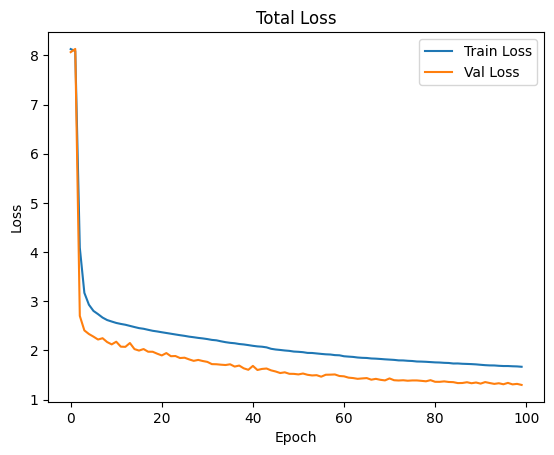

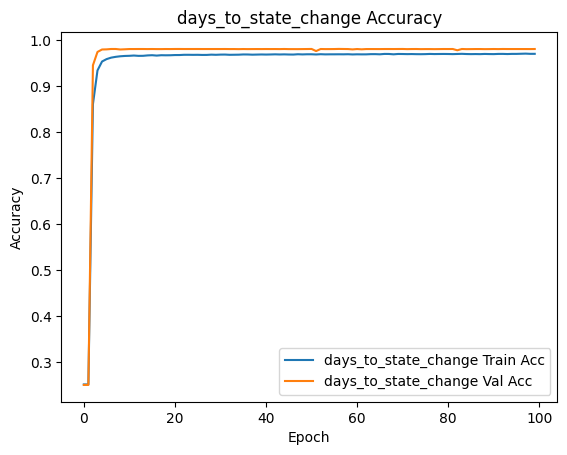

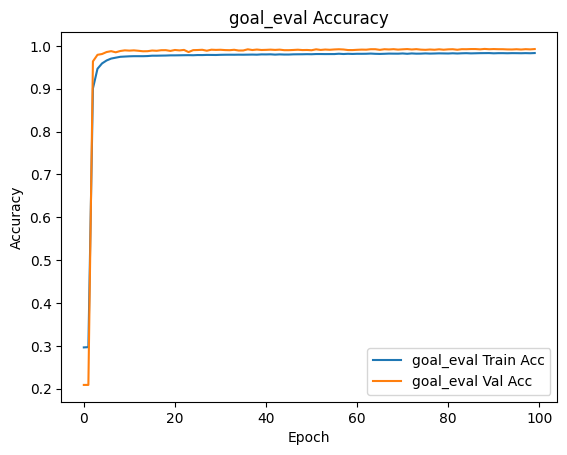

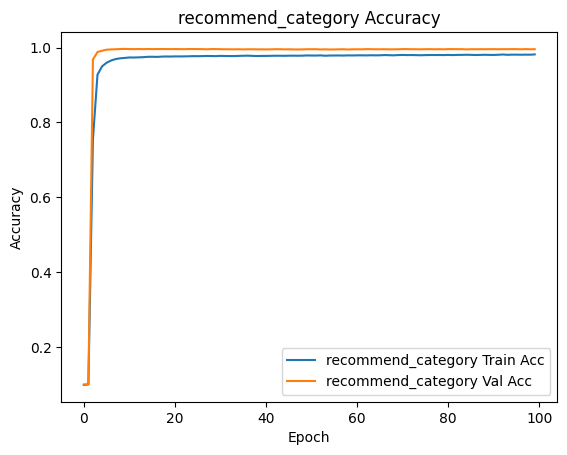

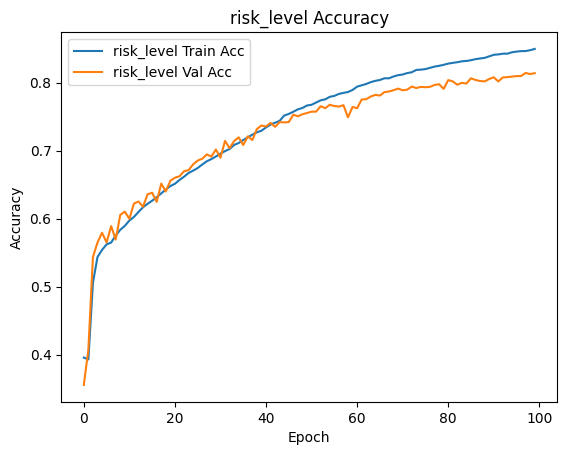

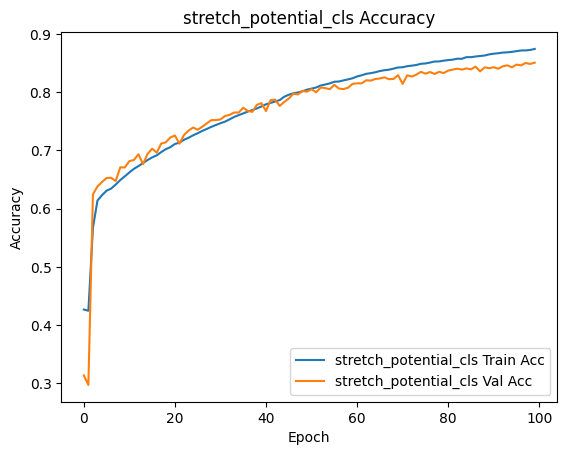

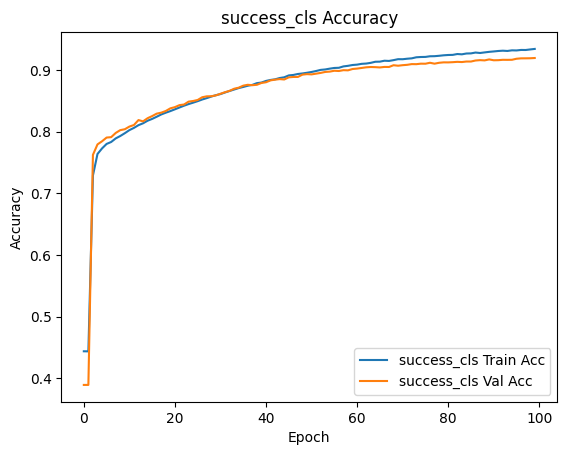

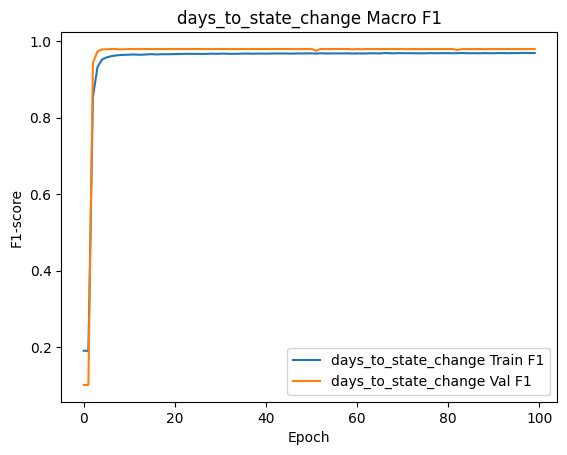

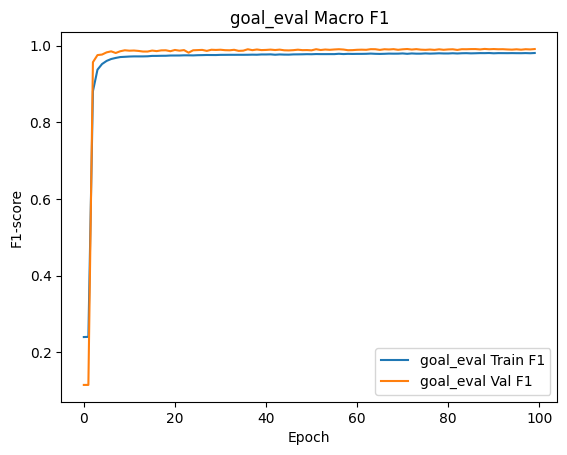

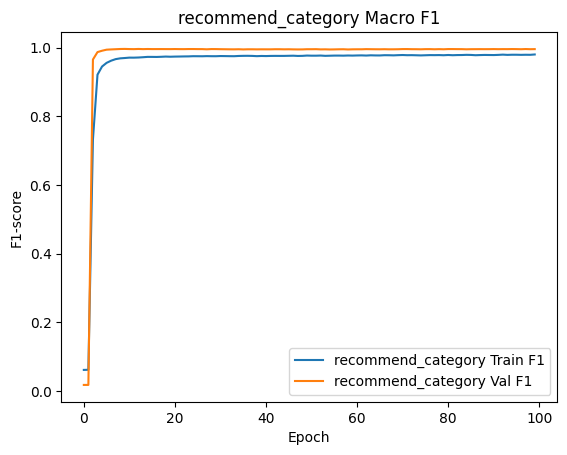

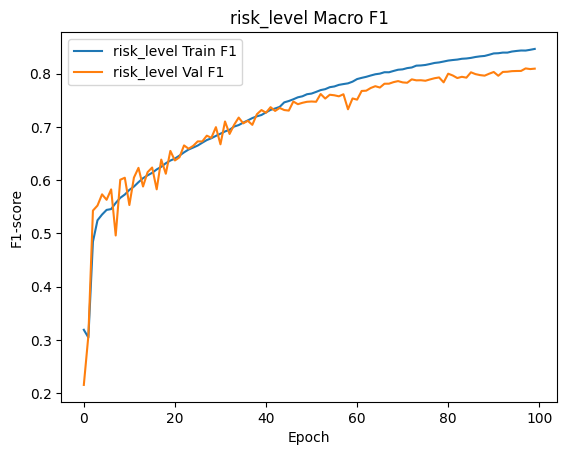

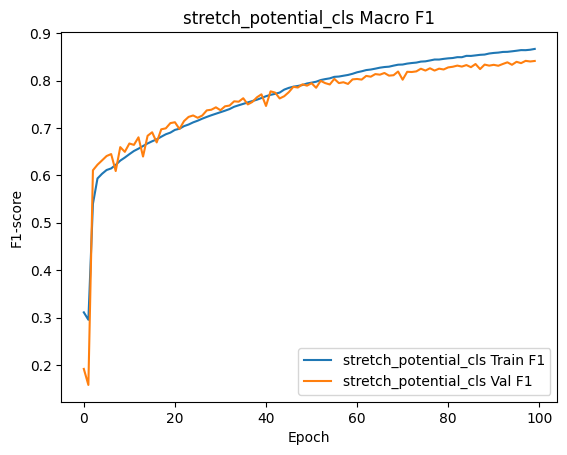

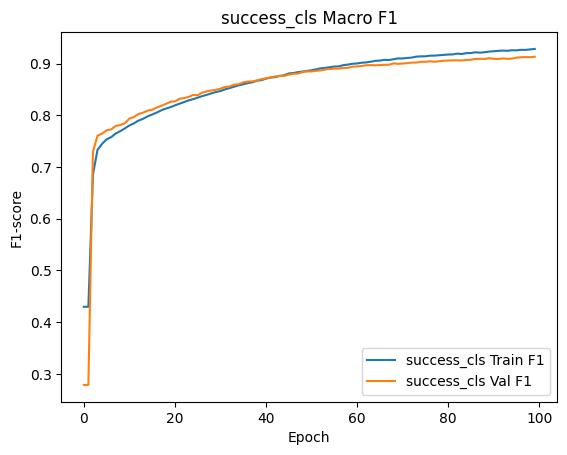

In [20]:

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

for head in history["train_acc"]:
    plt.figure()
    plt.plot(history["train_acc"][head], label=f"{head} Train Acc")
    plt.plot(history["val_acc"][head], label=f"{head} Val Acc")
    plt.legend()
    plt.title(f"{head} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

for head in history["train_f1"]:
    plt.figure()
    plt.plot(history["train_f1"][head], label=f"{head} Train F1")
    plt.plot(history["val_f1"][head], label=f"{head} Val F1")
    plt.legend()
    plt.title(f"{head} Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.show()


In [21]:

# torch.save(model.state_dict(), "model.pth")
# print("Model size (MB):", os.path.getsize("model.pth") / 1024**2)

In [22]:
import os, torch
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print("Model size (MB):", os.path.getsize("model.pth") / 1024**2)


Total params: 6,291,798
Trainable params: 6,291,798
Model size (MB): 6.905447959899902


In [23]:
torch.save(model.state_dict(), "tabm_pretrained.pt")

In [15]:
"""
AdaBoost SAMME.R for TabM (Multi-Head) — Warm Start + Per‑Epoch Metrics
======================================================================
• Works with your existing TabMBackboneMultiHead.
• Warm‑starts from your pretrained TabM (checkpoint or in‑memory).
• Logs per‑epoch metrics (train loss/acc, val loss/acc) for each boosting round.
• Keeps CE loss for all heads; supports light aug (feature dropout, cat mask, mixup).

Expected to exist in your scope:
  d_model_out_dim, n_cont_features, cat_cardinalities, head_dims, device
  train_loader_plain, val_loader  # yielding (x_cat, x_cont, y_dict)
Optionally: path to checkpoint 'tabm_pretrained.pt' (state_dict or entire model).
"""
from __future__ import annotations
import copy
from typing import Dict, List, Optional, Callable, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# ==========================
# Utilities
# ==========================

def _repeat_k_targets(t: torch.Tensor, k: int) -> torch.Tensor:
    return t.view(-1, 1).repeat(1, k).reshape(-1)


def _probs_from_logits(logits: torch.Tensor) -> torch.Tensor:
    """Return (B,C) probs. If logits=(B,k,C), average softmax over k."""
    if logits.dim() == 3:
        return logits.softmax(-1).mean(1)
    return logits.softmax(-1)


def feature_dropout(x_cont: Optional[torch.Tensor], drop_prob: float = 0.15) -> Optional[torch.Tensor]:
    if x_cont is None or drop_prob <= 0:
        return x_cont
    if not x_cont.is_floating_point():
        x_cont = x_cont.float()
    B, F = x_cont.shape
    mask = (torch.rand((B, F), device=x_cont.device) > drop_prob).float()
    return x_cont * mask


def cat_mask(x_cat: Optional[torch.Tensor], p: float = 0.10, unk_id: int = 0) -> Optional[torch.Tensor]:
    if x_cat is None or p <= 0:
        return x_cat
    m = (torch.rand_like(x_cat.float()) < p)
    return torch.where(m, torch.full_like(x_cat, unk_id), x_cat)


def mixup_cont(x_cont: Optional[torch.Tensor], alpha: float = 0.4):
    if x_cont is None or alpha <= 0:
        return x_cont, None, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x_cont.size(0), device=x_cont.device)
    x_mix = lam * x_cont + (1.0 - lam) * x_cont[idx]
    return x_mix, idx, lam


def soft_ce_from_logits(logits: torch.Tensor, y1: torch.Tensor, y2: torch.Tensor, lam: float) -> torch.Tensor:
    logp = F.log_softmax(logits, dim=-1)
    return lam * F.nll_loss(logp, y1, reduction='none') + (1.0 - lam) * F.nll_loss(logp, y2, reduction='none')


# ==========================
# Dataset / Loader (multi-head with per-head weights)
# ==========================
class MultiHeadDataset(Dataset):
    def __init__(self, x_cont: Optional[torch.Tensor], x_cat: Optional[torch.Tensor], y_dict: Dict[str, torch.Tensor]):
        self.x_cont, self.x_cat = x_cont, x_cat
        self.y_dict = {h: y.long() for h, y in y_dict.items()}
        Ns = {y.shape[0] for y in self.y_dict.values()}
        if len(Ns) != 1:
            raise ValueError("All heads must have same N")
        if self.x_cont is not None and self.x_cont.shape[0] not in Ns:
            raise ValueError("x_cont N mismatch")
        if self.x_cat is not None and self.x_cat.shape[0] not in Ns:
            raise ValueError("x_cat N mismatch")
        if self.x_cont is None and self.x_cat is None:
            raise ValueError("Need at least one of x_cont or x_cat")
        self.N = next(iter(Ns))

    def __len__(self):
        return self.N

    def __getitem__(self, i):
        xc = None if self.x_cont is None else self.x_cont[i]
        xa = None if self.x_cat is None else self.x_cat[i]
        yd = {h: y[i] for h, y in self.y_dict.items()}
        return i, xc, xa, yd


def make_weighted_loader_multiheads(
    ds,
    D_dict: dict,                    # {head: np.ndarray of shape (N,)}
    batch_size: int = 256,
    num_workers: int = 0,
    head_alpha: dict | None = None,  # ถ้าอยากเน้นบางหัว เช่น {"risk_level":2, ...}
    temp: float = 1.0,               # <<< ใหม่: temperature sharpening ของ sampling distribution
):
    """
    รวม distribution ต่อหัวเป็น distribution เดียว (mix) เพื่อใช้เป็น sampling weights
    - ถ้า head_alpha = None  -> เฉลี่ยเท่า ๆ กันทุกหัว
    - ถ้ามี head_alpha       -> เฉลี่ยถ่วงน้ำหนักตาม alpha ต่อหัว
    - temp < 1.0             -> เหลาคมขึ้น (โฟกัสตัวอย่างยาก/เบี้ยวบ่อย) / temp > 1.0 -> แบนลง
    """
    import numpy as np
    import torch
    from torch.utils.data import DataLoader, WeightedRandomSampler

    heads = list(D_dict.keys())
    N = len(ds)

    # 1) normalize D ต่อหัว + ตรวจ N ให้ตรง
    Dn = {}
    for h in heads:
        d = np.asarray(D_dict[h], dtype=np.float64)
        if d.shape[0] != N:
            raise ValueError(f"D_dict['{h}'] length {d.shape[0]} != N={N}")
        s = d.sum()
        if not np.isfinite(s) or s <= 0:
            d = np.ones(N, dtype=np.float64) / N
        Dn[h] = d / (d.sum() + 1e-12)

    # 2) ผสมเป็น mix (เฉลี่ย หรือถ่วงด้วย head_alpha)
    if head_alpha is None:
        mix = sum(Dn[h] for h in heads) / max(1, len(heads))
    else:
        mix = np.zeros(N, dtype=np.float64)
        total_a = 0.0
        for h in heads:
            a = float(head_alpha.get(h, 1.0))
            if a <= 0:
                continue
            mix += a * Dn[h]
            total_a += a
        if total_a <= 0:
            mix = sum(Dn[h] for h in heads) / max(1, len(heads))
        else:
            mix = mix / (total_a + 1e-12)

    # 3) temperature sharpening (ออปชัน)
    if temp is not None and temp > 0 and temp != 1.0:
        mix = np.power(np.maximum(mix, 1e-32), 1.0 / temp)
        mix = mix / (mix.sum() + 1e-12)

    # 4) ความปลอดภัยเชิงตัวเลข
    mix = np.clip(mix, 0, None)
    if not np.isfinite(mix).all() or mix.sum() <= 0:
        mix = np.ones(N, dtype=np.float64) / N

    weights = torch.as_tensor(mix, dtype=torch.double)
    sampler = WeightedRandomSampler(weights=weights, num_samples=N, replacement=True)

    # collate: MultiHeadDataset.__getitem__ -> (i, x_cont, x_cat, y_dict)
    def collate(batch):
        idxs, xcs, xas, ybs = zip(*batch)
        idxs = torch.as_tensor(idxs, dtype=torch.long, device='cpu')
        x_cont = None if xcs[0] is None else torch.stack(xcs, 0)
        x_cat  = None if xas[0] is None else torch.stack(xas, 0)
        heads  = list(ybs[0].keys())
        y_dict = {h: torch.stack([y[h] for y in ybs], 0) for h in heads}
        # คืน w_dict ที่ match กับ Dn (normalize แล้ว)
        # หมายเหตุ: ดึงด้วย idxs.cpu().numpy() กันเรื่อง pinned memory บาง backend
        w_dict = {h: torch.tensor(Dn[h][idxs.cpu().numpy()], dtype=torch.float32) for h in heads}
        return x_cont, x_cat, y_dict, w_dict

    return DataLoader(
        ds,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
        collate_fn=collate,
    )




# ==========================
# Train one multi-head base learner (per-head weights + optional aug)
# ==========================
class AugmentCfg:
    def __init__(self,
                 feat_dropout_p: float = 0.15,
                 catmask_p: float = 0.10,
                 cat_unk_id: int = 0,
                 mixup_heads: Optional[set] = None,
                 mixup_alpha: float = 0.4,
                 mixup_prob: float = 0.6):
        self.feat_dropout_p = feat_dropout_p
        self.catmask_p = catmask_p
        self.cat_unk_id = cat_unk_id
        self.mixup_heads = mixup_heads or set()
        self.mixup_alpha = mixup_alpha
        self.mixup_prob = mixup_prob


def _epoch_metrics(model: nn.Module,
                   heads: List[str],
                   x_cont_val: Optional[torch.Tensor],
                   x_cat_val: Optional[torch.Tensor],
                   y_val: Dict[str, torch.Tensor],
                   device: torch.device,
                   batch: int = 1024):
    model.eval()
    N = next(iter(y_val.values())).shape[0]
    total_loss, total_acc, counts = 0.0, 0.0, 0
    loss_heads: Dict[str, float] = {h: 0.0 for h in heads}
    acc_heads: Dict[str, float]  = {h: 0.0 for h in heads}
    with torch.no_grad():
        for i in range(0, N, batch):
            b = slice(i, min(i + batch, N))
            xc = x_cont_val[b].to(device) if x_cont_val is not None else None
            xa = x_cat_val[b].to(device) if x_cat_val is not None else None
            outs = model(xc, xa)
            for h in heads:
                logits = outs[h]
                y = y_val[h][b].to(device)
                if logits.dim() == 3:
                    B, k, C = logits.shape
                    loss_b = F.cross_entropy(logits.reshape(B * k, C), _repeat_k_targets(y, k))
                    prob = logits.softmax(-1).mean(1)
                else:
                    loss_b = F.cross_entropy(logits, y)
                    prob = logits.softmax(-1)
                pred = prob.argmax(1)
                acc_b = (pred == y).float().mean().item()
                loss_heads[h] += float(loss_b.item())
                acc_heads[h]  += acc_b
            counts += 1
    # average per head
    for h in heads:
        loss_heads[h] /= max(1, counts)
        acc_heads[h]  /= max(1, counts)
        total_loss += loss_heads[h]
        total_acc  += acc_heads[h]
    total_loss /= max(1, len(heads))
    total_acc  /= max(1, len(heads))
    return total_loss, total_acc, loss_heads, acc_heads


def train_one_multi(
    model: nn.Module,
    heads: List[str],
    loader: DataLoader,
    device: torch.device,
    epochs: int = 3,
    lr: float = 1e-3,
    clip: float = 1.0,
    aug: Optional[AugmentCfg] = None,
    val_data: Optional[Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Dict[str, torch.Tensor]]] = None,
    print_per_epoch: bool = False,
):
    """Train one base learner for a few epochs and (optionally) log per‑epoch metrics."""
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    aug = aug or AugmentCfg()

    history = []  # list of dicts per epoch

    for e in range(1, epochs + 1):
        model.train()
        loss_sum, acc_sum, n_batches = 0.0, 0.0, 0
        for x_cont, x_cat, y_dict, w_dict in loader:
            x_cont = x_cont.to(device) if x_cont is not None else None
            x_cat  = x_cat.to(device)  if x_cat  is not None else None
            y_dict = {h: y.to(device) for h, y in y_dict.items()}
            w_dict = {h: w.to(device) for h, w in w_dict.items()}

            # --- augmentation ---
            if x_cat is not None:
                x_cat = cat_mask(x_cat, p=aug.catmask_p, unk_id=aug.cat_unk_id)
            x_cont_clean = feature_dropout(x_cont, drop_prob=aug.feat_dropout_p) if x_cont is not None else None
            preds_clean = model(x_cont_clean, x_cat)

            # optional mixup for heads (only when logits are (B,C))
            mix_active = (np.random.rand() < aug.mixup_prob) and (aug.mixup_alpha > 0) and (x_cont_clean is not None)
            if mix_active:
                x_cont_mix, mix_idx, lam = mixup_cont(x_cont_clean, alpha=aug.mixup_alpha)
                preds_mix = model(x_cont_mix, x_cat)
            else:
                preds_mix, mix_idx, lam = None, None, 1.0

            total_loss = 0.0
            batch_acc = 0.0
            for h in heads:
                logits = preds_clean[h]
                y = y_dict[h]
                w = w_dict[h]

                if logits.dim() == 3:  # (B,k,C)
                    B, k, C = logits.shape
                    loss_i = F.cross_entropy(logits.reshape(B * k, C), _repeat_k_targets(y, k), reduction='none')
                    w_rep = w.view(-1, 1).repeat(1, k).reshape(-1)
                    loss_h = (loss_i * w_rep).sum() / (w_rep.sum() + 1e-12)
                    prob = logits.softmax(-1).mean(1)
                else:                   # (B,C)
                    if mix_active and (h in aug.mixup_heads) and preds_mix is not None:
                        logits_mix = preds_mix[h]
                        y1 = y
                        y2 = y1[mix_idx]
                        loss_i = soft_ce_from_logits(logits_mix, y1, y2, lam)
                        loss_h = (loss_i * w).sum() / (w.sum() + 1e-12)
                        prob = logits.softmax(-1)
                    else:
                        loss_i = F.cross_entropy(logits, y, reduction='none')
                        loss_h = (loss_i * w).sum() / (w.sum() + 1e-12)
                        prob = logits.softmax(-1)

                total_loss = total_loss + loss_h
                batch_acc += (prob.argmax(1) == y).float().mean().item()

            # average acc across heads for logging
            batch_acc /= max(1, len(heads))

            opt.zero_grad(set_to_none=True)
            total_loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()

            loss_sum += float(total_loss.item())
            acc_sum  += float(batch_acc)
            n_batches += 1

        train_loss_epoch = loss_sum / max(1, n_batches)
        train_acc_epoch  = acc_sum  / max(1, n_batches)

        if val_data is not None:
            vl, va, vloss_h, vacc_h = _epoch_metrics(model, heads, val_data[0], val_data[1], val_data[2], device)
        else:
            vl, va, vloss_h, vacc_h = float('nan'), float('nan'), {}, {}

        record = {
            'train_loss': train_loss_epoch,
            'train_acc': train_acc_epoch,
            'val_loss': vl,
            'val_acc': va,
            'val_loss_by_head': vloss_h,
            'val_acc_by_head': vacc_h,
        }
        history.append(record)

        if print_per_epoch:
            print(f"    epoch {e:02d} | train_loss={train_loss_epoch:.4f} train_acc={train_acc_epoch:.4f} | val_loss={vl:.4f} val_acc={va:.4f}")

    return history


# ==========================
# AdaBoost (SAMME.R) for all heads — with history logging
# ==========================
class AdaBoostTabM_SAMMER_Multi:
    """
    AdaBoost (SAMME.R) สำหรับ multi-head TabM พร้อมความสามารถ:
    - per-round gamma gating: ลอง gamma หลายค่า (รวมถึง 0) แล้ว "รับ" base learner ก็ต่อเมื่อ val score ดีขึ้นพอ
    - อัปเดต distribution D แบบนุ่ม (weight_lr, weight_smooth) กันยุบ/กระแทกกับ noisy
    - เก็บ gamma ต่อ estimator (per-estimator) และใช้รวมผลตอน predict_proba
    - ใช้ head_alpha ถ่วงน้ำหนักสกอร์บน val เพื่อโฟกัสหัวที่ยังอ่อน
    """
    def __init__(
        self,
        base_ctor: Callable[[], nn.Module],
        head_dims: Dict[str, int],
        n_estimators: int = 8,
        learning_rate: float = 0.8,      # ค่ามาตรฐานของ SAMME.R (ใช้เป็นจุดอ้างอิง)
        epochs_per_est: int = 3,
        optim_lr: float = 1e-3,
        device: Optional[torch.device] = None,
        aug: Optional[AugmentCfg] = None,
        head_alpha: Optional[Dict[str, float]] = None,
        # --- ใหม่: ตัวควบคุมการคัดกรองและเรียนรู้น้ำหนัก ---
        accept_gamma_grid: Optional[List[float]] = None,  # จะลอง gamma เหล่านี้ในแต่ละรอบ
        accept_min_gain: float = 1e-4,                    # รับถ้าดีกว่า baseline อย่างน้อยเท่านี้
        weight_lr: float = 0.4,                           # ความแรงในการอัปเดต D (ยิ่งเล็กยิ่งนุ่ม)
        weight_smooth: float = 0.10,                      # ผสม uniform ป้องกัน D ยุบ
        sampler_temp: float = 1.0,                        # ส่งต่อให้ sampler (เหลา distribution เวลา sampling)
    ):
        self.base_ctor = base_ctor
        self.head_dims = head_dims
        self.heads = list(head_dims.keys())
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.epochs_per_est = epochs_per_est
        self.optim_lr = optim_lr
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.estimators: List[nn.Module] = []
        self.estimator_gammas: List[float] = []  # <<< ใหม่: gamma ต่อ estimator
        self.aug = aug or AugmentCfg()
        self.history: List[Dict] = []
        self.head_alpha = head_alpha or {}
        # ค่ามาตรฐานของ grid ถ้าไม่ระบุ
        self.accept_gamma_grid = accept_gamma_grid or [learning_rate, learning_rate * 0.5, learning_rate * 0.25, 0.0]
        self.accept_min_gain = accept_min_gain
        self.weight_lr = weight_lr
        self.weight_smooth = weight_smooth
        self.sampler_temp = sampler_temp

    # ---------- ช่วยคำนวณ ----------
    @torch.no_grad()
    def _logP_all_heads(self, model: nn.Module, x_cont: Optional[torch.Tensor], x_cat: Optional[torch.Tensor], batch: int = 1024) -> Dict[str, torch.Tensor]:
        model.eval()
        N = x_cont.shape[0] if x_cont is not None else x_cat.shape[0]
        acc = {h: [] for h in self.heads}
        for i in range(0, N, batch):
            b = slice(i, min(i + batch, N))
            xc = x_cont[b].to(self.device) if x_cont is not None else None
            xa = x_cat[b].to(self.device) if x_cat is not None else None
            outs = model(xc, xa)
            for h in self.heads:
                prob = _probs_from_logits(outs[h]).detach().cpu()
                acc[h].append(torch.log(torch.clamp(prob, 1e-12)))
        return {h: torch.cat(acc[h], 0) for h in self.heads}

    @torch.no_grad()
    def _predict_logit_sum_with_extra(
        self,
        x_cont: Optional[torch.Tensor],
        x_cat: Optional[torch.Tensor],
        extra_estimator: Optional[nn.Module] = None,
        extra_gamma: float = 0.0,
        batch: int = 1024,
    ) -> Dict[str, torch.Tensor]:
        """รวม logits (log prob) จาก estimators ทั้งหมด + (ออปชัน) ตัว candidate เพิ่มเติม"""
        N = x_cont.shape[0] if x_cont is not None else x_cat.shape[0]
        agg = {h: torch.zeros((N, self.head_dims[h]), dtype=torch.float32) for h in self.heads}

        # ตัวที่มีอยู่แล้วใน ensemble
        for est, g in zip(self.estimators, self.estimator_gammas):
            est = est.to(self.device).eval()
            for i in range(0, N, batch):
                b = slice(i, min(i + batch, N))
                xc = x_cont[b].to(self.device) if x_cont is not None else None
                xa = x_cat[b].to(self.device) if x_cat is not None else None
                outs = est(xc, xa)
                for h in self.heads:
                    prob = _probs_from_logits(outs[h]).detach().cpu()
                    agg[h][b] += float(g) * torch.log(torch.clamp(prob, 1e-12))

        # candidate (ออปชัน)
        if extra_estimator is not None and extra_gamma is not None and extra_gamma != 0.0:
            ee = extra_estimator.to(self.device).eval()
            for i in range(0, N, batch):
                b = slice(i, min(i + batch, N))
                xc = x_cont[b].to(self.device) if x_cont is not None else None
                xa = x_cat[b].to(self.device) if x_cat is not None else None
                outs = ee(xc, xa)
                for h in self.heads:
                    prob = _probs_from_logits(outs[h]).detach().cpu()
                    agg[h][b] += float(extra_gamma) * torch.log(torch.clamp(prob, 1e-12))

        return agg  # ยังเป็น logit-sum ในโดเมน log

    @torch.no_grad()
    def _val_score(
        self,
        xcv: Optional[torch.Tensor],
        xav: Optional[torch.Tensor],
        yv: Dict[str, torch.Tensor],
        extra_estimator: Optional[nn.Module] = None,
        extra_gamma: float = 0.0,
    ) -> Tuple[float, Dict[str, float]]:
        """คืน (score รวมแบบถ่วงหัว, acc ต่อหัว) สำหรับใช้เลือก gamma"""
        agg = self._predict_logit_sum_with_extra(xcv, xav, extra_estimator, extra_gamma)
        acc_by_head = {}
        w_sum, score = 0.0, 0.0
        for h in self.heads:
            p = torch.softmax(agg[h], dim=1)
            pred = p.argmax(1)
            acc_h = (pred == yv[h].cpu()).float().mean().item()
            acc_by_head[h] = acc_h
            w = float(self.head_alpha.get(h, 1.0))
            w_sum += w
            score += w * acc_h
        if w_sum > 0:
            score /= w_sum
        return score, acc_by_head

    # ---------- API ฝั่งผู้ใช้ ----------
    def fit(
        self,
        x_cont: Optional[torch.Tensor],
        x_cat: Optional[torch.Tensor],
        y_dict: Dict[str, torch.Tensor],
        batch_size: int = 256,
        num_workers: int = 0,
        val_data: Optional[Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Dict[str, torch.Tensor]]] = None,
        print_val_per_round: bool = True,
        print_train_per_epoch: bool = True,
        init_D_dict: Optional[Dict[str, np.ndarray]] = None
    ):
        N = next(iter(y_dict.values())).shape[0]

        # init per-head distributions
        if init_D_dict is not None:
            D_dict = {h: init_D_dict[h].astype(np.float64) for h in self.heads}
            for h in self.heads:
                D_dict[h] = D_dict[h] / (D_dict[h].sum() + 1e-12)
        else:
            D_dict = {h: (np.ones(N, dtype=np.float64) / N) for h in self.heads}

        ds = MultiHeadDataset(x_cont, x_cat, y_dict)

        # baseline score ก่อนบูสต์ (กรณีมี pretrained ใน self.estimators)
        base_score = None
        if val_data is not None:
            xcv, xav, yv = val_data
            base_score, _ = self._val_score(xcv, xav, yv, None, 0.0)

        for t in range(self.n_estimators):
            print(f"[round {t+1}/{self.n_estimators}] training base learner...")
            loader = make_weighted_loader_multiheads(
                ds, D_dict,
                batch_size=batch_size,
                num_workers=num_workers,
                head_alpha=self.head_alpha,
                temp=self.sampler_temp,     # <<< ใหม่: ส่ง temp เข้า sampler
            )
            model = self.base_ctor()

            # ฝึก base learner พร้อม per-epoch metrics
            epochs_hist = train_one_multi(
                model, self.heads, loader, self.device,
                epochs=self.epochs_per_est, lr=self.optim_lr, aug=self.aug,
                val_data=val_data, print_per_epoch=print_train_per_epoch,
            )

            # ===== gamma-gating: ลอง gamma หลายค่า และตัดสินใจ "รับ/ข้าม" =====
            chosen_gamma = 0.0
            best_score = base_score
            best_accs = None

            if val_data is not None:
                xcv, xav, yv = val_data
                for g in self.accept_gamma_grid:
                    sc, accs = self._val_score(xcv, xav, yv, extra_estimator=model, extra_gamma=g)
                    if (best_score is None) or (sc > best_score + self.accept_min_gain):
                        best_score = sc
                        chosen_gamma = g
                        best_accs = accs
            else:
                # ถ้าไม่มี val ให้รับตามปกติด้วย gamma = learning_rate
                chosen_gamma = self.learning_rate

            round_rec = {'epochs': epochs_hist}

            if chosen_gamma == 0.0:
                # ข้ามรอบนี้ (ไม่รับ model)
                round_rec['accepted'] = False
                round_rec['gamma'] = 0.0
                if print_val_per_round and val_data is not None and best_accs is not None:
                    print(f"[round {t+1}] skipped (no gain). ensemble val acc (per head): {best_accs}")
                self.history.append(round_rec)
                # ไม่อัปเดต D_dict, ไม่แตะ base_score
                continue

            # ===== ยอมรับ base learner นี้ด้วย gamma ที่เลือก =====
            # 1) อัปเดต D ด้วย SAMME.R + ทำให้นุ่มลง (คูณด้วย weight_lr และ smooth)
            logP = self._logP_all_heads(model, x_cont, x_cat, batch=1024)
            gamma_scale = float(chosen_gamma) / float(self.learning_rate if self.learning_rate != 0 else 1.0)

            for h in self.heads:
                y = y_dict[h].long().cpu()
                K = self.head_dims[h]
                L = logP[h]                             # log prob ต่อคลาส
                logP_true = L[torch.arange(N), y]
                mean_logP = L.mean(dim=1)
                margin = (K - 1) / K * (logP_true - mean_logP)  # SAMME.R margin

                # อัปเดตแบบนุ่ม: ลดสเต็ปด้วย weight_lr และสเกลด้วยสัดส่วน gamma
                D = D_dict[h]
                step = - self.weight_lr * gamma_scale * margin.numpy()
                D_new = D * np.exp(step)
                D_new = D_new / (D_new.sum() + 1e-12)

                # ผสม uniform เล็กน้อยให้เสถียร
                if self.weight_smooth > 0:
                    uni = np.ones_like(D_new, dtype=np.float64) / len(D_new)
                    D_new = (1.0 - self.weight_smooth) * D_new + self.weight_smooth * uni
                    D_new = D_new / (D_new.sum() + 1e-12)

                D_dict[h] = D_new

            # 2) เก็บ estimator + gamma
            self.estimators.append(copy.deepcopy(model).cpu())
            self.estimator_gammas.append(float(chosen_gamma))

            # 3) ปรับ baseline score และบันทึกผล val ของ ensemble ล่าสุด
            if val_data is not None:
                base_score = best_score  # อัปเดตฐาน
                # รายงาน acc ต่อหัวหลังรวม
                _, accs_now = self._val_score(xcv, xav, yv, None, 0.0)
                round_rec['accepted'] = True
                round_rec['gamma'] = float(chosen_gamma)
                round_rec['val_acc_after_round'] = accs_now
                if print_val_per_round:
                    print(f"[round {t+1}] ensemble val acc (per head): {accs_now}")

            self.history.append(round_rec)

    # ---------- พยากรณ์ ----------
    @torch.no_grad()
    def predict_proba(self, x_cont: Optional[torch.Tensor], x_cat: Optional[torch.Tensor], batch: int = 1024) -> Dict[str, torch.Tensor]:
        agg = self._predict_logit_sum_with_extra(x_cont, x_cat, None, 0.0, batch)
        return {h: torch.softmax(agg[h], dim=1) for h in self.heads}

    @torch.no_grad()
    def predict(self, x_cont: Optional[torch.Tensor], x_cat: Optional[torch.Tensor], batch: int = 1024) -> Dict[str, torch.Tensor]:
        proba = self.predict_proba(x_cont, x_cat, batch)
        return {h: p.argmax(1) for h, p in proba.items()}



# ==========================
# Helper — stack tensors from an existing DataLoader
# ==========================
# loader yields (x_cat, x_cont, y_dict)  by default. Use order="cont_cat_y" if swapped.

def stack_from_loader(loader, order: str = "cat_cont_y") -> Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Dict[str, torch.Tensor]]:
    xs_cont, xs_cat = [], []
    ys = {h: [] for h in head_dims.keys()}
    for batch in loader:
        if order == "cat_cont_y":
            x_cat_b, x_cont_b, y_dict_b = batch
        elif order == "cont_cat_y":
            x_cont_b, x_cat_b, y_dict_b = batch
        else:
            raise ValueError("order must be 'cat_cont_y' or 'cont_cat_y'")
        if x_cont_b is not None: xs_cont.append(x_cont_b.cpu())
        if x_cat_b  is not None: xs_cat.append(x_cat_b.cpu())
        for h in ys: ys[h].append(y_dict_b[h].cpu())
    x_cont = torch.cat(xs_cont, 0) if xs_cont else None
    x_cat  = torch.cat(xs_cat,  0) if xs_cat  else None
    y_dict = {h: torch.cat(ys[h], 0) for h in ys}
    return x_cont, x_cat, y_dict


# ==========================
# Warm‑start helpers (optional D init)
# ==========================
@torch.no_grad()
def compute_initial_D_from_model(model: nn.Module,
                                 x_cont: Optional[torch.Tensor],
                                 x_cat: Optional[torch.Tensor],
                                 y_dict: Dict[str, torch.Tensor],
                                 head_dims: Dict[str, int],
                                 learning_rate: float,
                                 device: torch.device,
                                 batch: int = 1024) -> Dict[str, np.ndarray]:
    model = model.to(device).eval()
    N = next(iter(y_dict.values())).shape[0]
    acc = {h: [] for h in head_dims.keys()}
    for i in range(0, N, batch):
        b = slice(i, min(i + batch, N))
        xc = x_cont[b].to(device) if x_cont is not None else None
        xa = x_cat[b].to(device) if x_cat is not None else None
        outs = model(xc, xa)
        for h in head_dims.keys():
            prob = _probs_from_logits(outs[h]).detach().cpu()
            acc[h].append(torch.log(torch.clamp(prob, 1e-12)))
    logP = {h: torch.cat(acc[h], 0) for h in head_dims.keys()}

    D_init: Dict[str, np.ndarray] = {}
    for h, K in head_dims.items():
        L = logP[h]
        y = y_dict[h].long().cpu()
        logP_true = L[torch.arange(N), y]
        mean_logP = L.mean(dim=1)
        margin = (K - 1) / K * (logP_true - mean_logP)
        D = np.exp(- learning_rate * margin.numpy())
        D_init[h] = D / (D.sum() + 1e-12)
    return D_init


# ==========================
# Robust checkpoint loader (state_dict or whole model)
# ==========================

def _strip_prefix(sd, prefix):
    if not all(k.startswith(prefix) for k in sd.keys()):
        return sd
    return {k[len(prefix):]: v for k, v in sd.items()}


def load_tabm_from_ckpt(ckpt_path, make_model, map_location="cpu", strict=True):
    obj = torch.load(ckpt_path, map_location=map_location)
    if not isinstance(obj, dict) or any(hasattr(obj, a) for a in ["forward", "parameters"]):
        pretrained = obj
        pretrained.eval()
        for p in pretrained.parameters():
            p.requires_grad = False
        return pretrained
    candidate_keys = ["state_dict", "model_state", "model", "net", "weights"]
    sd = None
    for k in candidate_keys:
        if k in obj and isinstance(obj[k], dict):
            sd = obj[k]; break
    if sd is None:
        sd = obj
    sd_try = [_strip_prefix(sd, "module."), _strip_prefix(sd, "model."), sd]
    model = make_model()
    last_err = None
    for sd_i in sd_try:
        try:
            model.load_state_dict(sd_i, strict=strict)
            model.eval()
            for p in model.parameters():
                p.requires_grad = False
            return model
        except RuntimeError as e:
            last_err = e; continue
    raise RuntimeError(f"Failed to load state_dict into model. Last error: {last_err}")


# ==========================
# Factory — build your multi‑head TabM
# ==========================
# Requires: TabMBackboneMultiHead, d_model_out_dim, n_cont_features, cat_cardinalities, head_dims

def make_base_multi() -> nn.Module:
    return TabMMultiHead(
        n_num_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        head_dims=head_dims,
        k=14,
        d_block=d_model_out_dim,
        n_blocks=5,
        dropout=0.3,
        start_scaling_init="normal",
        # start_scaling_init_chunks=None,
    )



# ==========================
# Example usage
# ==========================
if __name__ == "__main__":
    # 1) Prepare tensors from your loaders (set order if needed)
    x_cont_tr, x_cat_tr, y_tr = stack_from_loader(train_loader_plain, order="cat_cont_y")  # noqa: F821
    x_cont_va, x_cat_va, y_va = stack_from_loader(val_loader,        order="cat_cont_y")  # noqa: F821

    # 2) Load your pretrained TabM — choose ONE of the following:
    # (A) If you already have `model` in memory:
    # pretrained = copy.deepcopy(model).cpu()  # noqa: F821

    # (B) Or load from checkpoint file (supports state_dict or whole model):
    ckpt_path = "tabm_pretrained.pt"  # change to your path
    pretrained = load_tabm_from_ckpt(ckpt_path, make_base_multi, map_location="cpu", strict=True)

    # 3) Booster config + augment
    aug_cfg = AugmentCfg(
        feat_dropout_p=0.15,
        catmask_p=0.10,
        cat_unk_id=0,
        mixup_heads={"risk_level", "stretch_potential_cls"},
        mixup_alpha=0.4,
        mixup_prob=0.6,
    )

    booster = AdaBoostTabM_SAMMER_Multi(
        base_ctor=make_base_multi,
        head_dims=head_dims,
        n_estimators=10,
        epochs_per_est=2,
        optim_lr=1e-4,
        learning_rate=0.6,
        device=device,
        aug=aug_cfg,
    )
        # เน้นหัวที่ยังอ่อนบน val (เช่น risk_level, stretch)
    booster.head_alpha = {
        "risk_level": 3.0,
        "stretch_potential_cls": 2.0,
        "success_cls": 1.0,
        "goal_eval": 0.0,
        "recommend_category": 0.0,
        "days_to_state_change": 0.0,
    }

    # ลอง gamma หลายระดับ รวม 0 (หมายถึง “ไม่รับ”)
    booster.accept_gamma_grid = [
        booster.learning_rate, booster.learning_rate*0.5, booster.learning_rate*0.25, 0.0
    ]
    booster.accept_min_gain = 1e-4         # ถ้า noisy มาก ค่อย ๆ เพิ่มได้
    booster.weight_lr = 0.3                # อัปเดต D ให้นุ่มลงหน่อย
    booster.weight_smooth = 0.10           # กัน D ยุบ/ชี้ไปจุดเดิม
    booster.sampler_temp = 0.7             # ให้ sampler เหลาคมขึ้น โฟกัสตัวอย่างยาก

    # 4) Warm‑start ensemble with your pretrained TabM
    booster.estimators.append(pretrained)

    # 5) Initialize D from pretrained margins (optional but recommended)
    D_init = compute_initial_D_from_model(pretrained, x_cont_tr, x_cat_tr, y_tr, head_dims, booster.learning_rate, device)

    # 6) Fit remaining boosted models — logs per‑epoch metrics automatically
    booster.fit(
        x_cont_tr, x_cat_tr, y_tr,
        batch_size=512,
        val_data=(x_cont_va, x_cat_va, y_va),
        print_val_per_round=True,
        print_train_per_epoch=True,
        init_D_dict=D_init,
    )

    # Access full history:
    # booster.history[round]['epochs'][e] -> {'train_loss','train_acc','val_loss','val_acc',...}

    # 7) Evaluate final ensemble
    proba_val = booster.predict_proba(x_cont_va, x_cat_va)
    pred_val  = booster.predict(x_cont_va, x_cat_va)
    accs = {h: (pred_val[h] == y_va[h]).float().mean().item() for h in head_dims}
    print("Final VAL acc per head:", accs)


[round 1/10] training base learner...
    epoch 01 | train_loss=6.0401 train_acc=0.4867 | val_loss=0.9249 val_acc=0.5618
    epoch 02 | train_loss=5.3473 train_acc=0.6058 | val_loss=0.7885 val_acc=0.6190
[round 1] ensemble val acc (per head): {'success_cls': 0.9191617965698242, 'risk_level': 0.8140180706977844, 'days_to_state_change': 0.9806159734725952, 'recommend_category': 0.995665967464447, 'goal_eval': 0.992506742477417, 'stretch_potential_cls': 0.8503889441490173}
[round 2/10] training base learner...
    epoch 01 | train_loss=6.4291 train_acc=0.5031 | val_loss=0.8131 val_acc=0.6172
    epoch 02 | train_loss=5.6916 train_acc=0.6219 | val_loss=0.7312 val_acc=0.6522
[round 2] ensemble val acc (per head): {'success_cls': 0.9176536202430725, 'risk_level': 0.8182092308998108, 'days_to_state_change': 0.9805683493614197, 'recommend_category': 0.9956341981887817, 'goal_eval': 0.9924432635307312, 'stretch_potential_cls': 0.851801872253418}
[round 3/10] training base learner...
    epoch 0

In [ ]:
import os, torch
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print("Model size (MB):", os.path.getsize("model.pth") / 1024**2)
